In [1]:
# =============================================================================
# 数据读取和初始处理
# =============================================================================

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 候选路径：优先使用你提供的路径，其次尝试常见的 OneDrive 目录
candidate_paths = [
    Path("/onedrive/rotman/mbh/MBH_main.csv"),
    Path("/Users/xingjianzhang/Library/CloudStorage/OneDrive-个人/rotman/MBH/MBH_main.csv"),
    Path.home() / "Library/CloudStorage/OneDrive-个人/rotman/MBH/MBH_main.csv",
    Path(r"C:\Users\zhang\OneDrive\rotman\mbh\MBH_main.csv"),
]

csv_path = next((p for p in candidate_paths if p.exists()), candidate_paths[0])
if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found. Tried: {candidate_paths}")

# 读取 CSV（带 BOM 时使用 utf-8-sig 更稳妥）
df_raw = pd.read_csv(csv_path, encoding="utf-8-sig")
print(f"第1步 - 数据读取完成: {csv_path} | 形状={df_raw.shape}")

第1步 - 数据读取完成: C:\Users\zhang\OneDrive\rotman\mbh\MBH_main.csv | 形状=(1352, 79)


In [2]:
# =============================================================================
# 第2步：删除不需要的抬头行
# =============================================================================

print(f"第2步 - 删除抬头行")
print(f"处理前数据量: {df_raw.shape[0]}")

# 检查并显示StartDate列的前几个值
print(f"StartDate列的前10个值: {df_raw['StartDate'].head(10).tolist()}")

# 删除两个不需要的抬头行
df_step2 = df_raw[
    (df_raw['StartDate'] != "Start Date") & 
    (df_raw['StartDate'] != '{"ImportId":"startDate","timeZone":"America/New_York"}')
].copy()

print(f"处理后数据量: {df_step2.shape[0]}")
print(f"删除了 {df_raw.shape[0] - df_step2.shape[0]} 行抬头数据")

# 重置索引
df_step2.reset_index(drop=True, inplace=True)

第2步 - 删除抬头行
处理前数据量: 1352
StartDate列的前10个值: ['Start Date', '{"ImportId":"startDate","timeZone":"America/New_York"}', '2025-08-18 10:00:12', '2025-08-18 09:57:50', '2025-08-18 09:58:40', '2025-08-18 09:57:48', '2025-08-18 09:57:13', '2025-08-18 10:02:46', '2025-08-18 09:57:59', '2025-08-18 10:00:05']
处理后数据量: 1350
删除了 2 行抬头数据


In [3]:
# =============================================================================
# 第3步：处理重复的Prolific ID
# =============================================================================

print(f"第3步 - 处理重复参与者")

# 找出重复的Prolific ID
duplicate_ids = df_step2[df_step2.duplicated(subset=['Prolific ID'], keep=False)]
print(f"发现重复的Prolific ID记录: {len(duplicate_ids)} 条")

if len(duplicate_ids) > 0:
    print("重复的Prolific ID详情:")
    print(duplicate_ids[['Prolific ID', 'StartDate', 'EndDate']])

# 删除指定的重复ID
duplicate_prolific_ids = ["643db5baa695a720a1bbdb4f", "6773a4f19e0b5c2d84f6a913"]
df_step3 = df_step2[~df_step2['Prolific ID'].isin(duplicate_prolific_ids)].copy()

print(f"删除重复ID后数据量: {df_step3.shape[0]}")
print(f"删除了 {df_step2.shape[0] - df_step3.shape[0]} 条重复记录")

第3步 - 处理重复参与者
发现重复的Prolific ID记录: 4 条
重复的Prolific ID详情:
                   Prolific ID            StartDate              EndDate
240   643db5baa695a720a1bbdb4f  2025-08-18 10:57:09  2025-08-18 11:02:10
317   643db5baa695a720a1bbdb4f  2025-08-18 11:11:27  2025-08-18 11:20:04
998   6773a4f19e0b5c2d84f6a913  2025-08-20 09:53:53  2025-08-20 09:56:40
1109  6773a4f19e0b5c2d84f6a913  2025-08-20 11:25:22  2025-08-20 11:28:37
删除重复ID后数据量: 1346
删除了 4 条重复记录


In [4]:
# =============================================================================
# 第4步：数据宽转长处理
# =============================================================================

print(f"第4步 - 数据宽转长处理")

# 识别所有实验变量
hr_vars = [col for col in df_step3.columns if col.startswith('HR_')]
med_vars = [col for col in df_step3.columns if col.startswith('Med_')]
experiment_vars = hr_vars + med_vars

print(f"找到实验变量 {len(experiment_vars)} 个:")
print(f"  HR变量: {len(hr_vars)} 个")
print(f"  Med变量: {len(med_vars)} 个")

# 检查每个变量的非缺失值数量
non_missing_counts = {var: df_step3[var].notna().sum() for var in experiment_vars}
print(f"各变量非缺失值范围: {min(non_missing_counts.values())} - {max(non_missing_counts.values())}")

# 执行宽转长操作
df_step4 = df_step3.melt(
    id_vars=[col for col in df_step3.columns if col not in experiment_vars],
    value_vars=experiment_vars,
    var_name='original_var',
    value_name='original_answer'
)

# 只保留非缺失的观测值
df_step4 = df_step4[df_step4['original_answer'].notna()].copy()
df_step4.reset_index(drop=True, inplace=True)

print(f"宽转长完成: {df_step3.shape} → {df_step4.shape}")

第4步 - 数据宽转长处理
找到实验变量 36 个:
  HR变量: 18 个
  Med变量: 18 个
各变量非缺失值范围: 34 - 40
宽转长完成: (1346, 79) → (1346, 45)


In [5]:
# =============================================================================
# 第5步：解析实验条件变量
# =============================================================================

print(f"第5步 - 解析实验条件")

# 按下划线拆分 original_var → 5列
split_cols = df_step4['original_var'].astype(str).str.split('_', n=4, expand=True)
split_cols.columns = ['report_type', 'source_type', 'information', 'analysis', 'recommendation']

# 合并到主数据框
df_step5 = pd.concat([df_step4, split_cols], axis=1)

print(f"解析完成，新增5个条件变量:")
print(f"  report_type: {df_step5['report_type'].unique()}")
print(f"  source_type: {df_step5['source_type'].unique()}")
print(f"  information: {df_step5['information'].unique()}")
print(f"  analysis: {df_step5['analysis'].unique()}")
print(f"  recommendation: {df_step5['recommendation'].unique()}")

第5步 - 解析实验条件
解析完成，新增5个条件变量:
  report_type: ['HR' 'Med']
  source_type: ['AI' 'Human']
  information: ['no' 'yes' 'none']
  analysis: ['no' 'yes' None]
  recommendation: ['no' 'yes' None 'ye']


In [6]:
# =============================================================================
# 第6步：创建分析变量
# =============================================================================

print(f"第6步 - 创建分析变量")

# 创建AI披露变量
df_step6 = df_step5.copy()
df_step6['AI_disclosure'] = (df_step6['information'] != 'none')

# 创建是否遵循推荐变量
df_step6['followed_recommendation'] = df_step6['original_answer'].isin([
    'Kinetic Workforce (KNTC)', 
    'Vista Therapeutics (VSTA)'
])

# 创建条件组合变量
df_step6['condition'] = df_step6['original_var'].str.split('_', n=2).str[2]

print(f"创建的分析变量:")
print(f"  AI_disclosure: {df_step6['AI_disclosure'].value_counts()}")
print(f"  followed_recommendation: {df_step6['followed_recommendation'].value_counts()}")
print(f"  condition分布: {len(df_step6['condition'].unique())} 种不同条件")

第6步 - 创建分析变量
创建的分析变量:
  AI_disclosure: AI_disclosure
True     1196
False     150
Name: count, dtype: int64
  followed_recommendation: followed_recommendation
True     691
False    655
Name: count, dtype: int64
  condition分布: 10 种不同条件


In [7]:
# =============================================================================
# 第7步：数据清理和标准化
# =============================================================================

print(f"第7步 - 数据清理和标准化")

# 复制数据进行最终清理
df_clean = df_step6.copy()

# 修正数据不一致性
# 1. 修正 recommendation 中的 "ye" → "yes"
before_fix = df_clean['recommendation'].value_counts()
df_clean['recommendation'] = df_clean['recommendation'].replace('ye', 'yes')
after_fix = df_clean['recommendation'].value_counts()
print(f"修正recommendation: ye → yes")

# 2. 将 information 中的 "none" 转为缺失值
df_clean['information'] = df_clean['information'].replace('none', pd.NA)

# 3. 同步修正 condition 中的对应问题
df_clean['condition'] = df_clean['condition'].replace('yes_yes_ye', 'yes_yes_yes')

# 4. 确保字符串格式统一
df_clean['original_var'] = df_clean['original_var'].astype(str).str.strip()

# 5. 将量表题（如“4=Neutral”）仅保留开头数字并转为数值
likert_prefixes = [
    'Originality and nove_',
    'Accountability_',
    'Transparency_',
    'Reliability_',
]
likert_exact = ['Effort_1', 'Time of preparation_1']
likert_cols = [c for c in df_clean.columns if any(c.startswith(p) for p in likert_prefixes)]
likert_cols += [c for c in likert_exact if c in df_clean.columns]
likert_cols = list(dict.fromkeys(likert_cols))
if len(likert_cols) > 0:
    # 提取开头数字；不存在数字则为缺失
    df_clean[likert_cols] = df_clean[likert_cols].replace(r'^\s*(\d+).*$' , r'\1', regex=True)
    df_clean[likert_cols] = df_clean[likert_cols].apply(pd.to_numeric, errors='coerce').astype('Int64')
    print(f"数值化清洗列数: {len(likert_cols)} | 示例列: {likert_cols[:5]}")

print(f"数据清理完成！")
print(f"最终数据形状: {df_clean.shape}")
print(f"关键变量检查:")
print(f"  information缺失值: {df_clean['information'].isna().sum()}")
print(f"  recommendation唯一值: {df_clean['recommendation'].unique()}")
print(f"  AI_disclosure分布: {df_clean['AI_disclosure'].value_counts()}")

print(f"\n=== 数据清洗流程完成 ===")
print(f"原始数据: {df_raw.shape} → 最终数据: {df_clean.shape}")
print(f"最终数据集已保存为: df_clean")

# rename Originality and nove_1 to originality_1
df_clean.rename(columns={'Originality and nove_1': 'originality_1', 'Originality and nove_2': 'originality_2', 'Originality and nove_3': 'originality_3', 'Originality and nove_4': 'originality_4'}, inplace=True)

# rename time of preparation_1 to preparation_time
df_clean.rename(columns={'Time of preparation_1': 'preparation_time'}, inplace=True)


# rename Accountability_1 to accountability_1, Accountability_2 to accountability_2, Accountability_3 to accountability_3, Accountability_4 to accountability_4
df_clean.rename(columns={'Accountability_1': 'accountability_1', 'Accountability_2': 'accountability_2', 'Accountability_3': 'accountability_3', 'Accountability_4': 'accountability_4'}, inplace=True)

# rename Transparency_1 to transparency_1, Transparency_2 to transparency_2, Transparency_3 to transparency_3, Transparency_4 to transparency_4
df_clean.rename(columns={'Transparency_1': 'transparency_1', 'Transparency_2': 'transparency_2', 'Transparency_3': 'transparency_3', 'Transparency_4': 'transparency_4'}, inplace=True)

# rename Accountability_1 to accountability_1, Accountability_2 to accountability_2, Accountability_3 to accountability_3, Accountability_4 to accountability_4
df_clean.rename(columns={'Accountability_1': 'accountability_1', 'Accountability_2': 'accountability_2', 'Accountability_3': 'accountability_3', 'Accountability_4': 'accountability_4'}, inplace=True)

# rename Reliability_1 to reliability_1, Reliability_2 to reliability_2, Reliability_3 to reliability_3, Reliability_4 to reliability_4
df_clean.rename(columns={'Reliability_1': 'reliability_1', 'Reliability_2': 'reliability_2', 'Reliability_3': 'reliability_3', 'Reliability_4': 'reliability_4'}, inplace=True)


### reverse coding

# likert 1-7 points； reverse coding originality_3, originality_4
df_clean['originality_3'] = 8 - df_clean['originality_3']
df_clean['originality_4'] = 8 - df_clean['originality_4']

# reverse coding accountability_3, accountability_4
df_clean['accountability_3'] = 8 - df_clean['accountability_3']
df_clean['accountability_4'] = 8 - df_clean['accountability_4']

# reverse coding transparency_2, transparency_4
df_clean['transparency_2'] = 8 - df_clean['transparency_2']
df_clean['transparency_4'] = 8 - df_clean['transparency_4']

# reverse coding reliability_2, reliability_4
df_clean['reliability_2'] = 8 - df_clean['reliability_2']
df_clean['reliability_4'] = 8 - df_clean['reliability_4']




第7步 - 数据清理和标准化
修正recommendation: ye → yes
数值化清洗列数: 18 | 示例列: ['Originality and nove_1', 'Originality and nove_2', 'Originality and nove_3', 'Originality and nove_4', 'Accountability_1']
数据清理完成！
最终数据形状: (1346, 53)
关键变量检查:
  information缺失值: 150
  recommendation唯一值: ['no' 'yes' None]
  AI_disclosure分布: AI_disclosure
True     1196
False     150
Name: count, dtype: int64

=== 数据清洗流程完成 ===
原始数据: (1352, 79) → 最终数据: (1346, 53)
最终数据集已保存为: df_clean


In [8]:



# 生成回答正确的数据集(filter if original_answer == "Hamilton Sterling Group (HSG)" | "Vista Therapeutics (VSTA)")，只保留prolific_id变量和original_answer变量
df_correct = df_clean[df_clean['original_answer'].isin(["Hamilton Sterling Group (HSG)", "Vista Therapeutics (VSTA)"])]
df_correct = df_correct[['Prolific ID', 'original_answer']]

# 在末尾加入两个观测值，prolific_id为643db5baa695a720a1bbdb4f和6773a4f19e0b5c2d84f6a913
df_correct = pd.concat([df_correct, pd.DataFrame({'Prolific ID': ['643db5baa695a720a1bbdb4f', '6773a4f19e0b5c2d84f6a913'], 'original_answer': ['Hamilton Sterling Group (HSG)', 'Vista Therapeutics (VSTA)']})])

import pandas as pd
import hashlib

# 从notebook的代码中，我已经知道df_correct已经创建好了
# 现在实现哈希值随机化

def hash_based_random_selection(df, prolific_id_col, seed=20250904, n_select=3):
    """
    基于Prolific ID值本身进行哈希随机化抽样
    
    Parameters:
    - df: 包含Prolific ID的数据框
    - prolific_id_col: Prolific ID列名
    - seed: 随机种子
    - n_select: 选择的数量
    
    Returns:
    - df_with_bonus: 包含pay变量的数据框
    - selected_ids: 被选中的ID列表
    """
    
    # 获取所有唯一的Prolific ID
    unique_ids = df[prolific_id_col].dropna().unique()
    
    print(f"总共有 {len(unique_ids)} 个唯一的Prolific ID")
    
    # 为每个ID生成确定性的哈希随机值
    id_hash_pairs = []
    
    for pid in unique_ids:
        # 将ID和seed组合后进行MD5哈希
        combined_string = f"{pid}_{seed}"
        hash_value = hashlib.md5(combined_string.encode()).hexdigest()
        
        # 将32位十六进制哈希值转换为0-1之间的浮点数
        # 使用前8位十六进制（相当于32位二进制）
        random_value = int(hash_value[:8], 16) / (16**8)
        
        id_hash_pairs.append((pid, random_value))
    
    # 按哈希随机值排序并选择前n_select个
    id_hash_pairs.sort(key=lambda x: x[1])
    selected_ids = [pair[0] for pair in id_hash_pairs[:n_select]]
    
    print(f"\n使用seed {seed} 选出的 {n_select} 个bonus获得者:")
    for i, selected_id in enumerate(selected_ids, 1):
        print(f"{i}. {selected_id}")
    
    # 为数据框添加pay变量
    df_result = df.copy()
    df_result['pay'] = df_result[prolific_id_col].apply(
        lambda x: 201.2 if x in selected_ids else 1.2
    )
    
    print(f"\nPay变量统计:")
    pay_stats = df_result['pay'].value_counts().sort_index()
    print(f"获得bonus (201.2): {pay_stats.get(201.2, 0)} 人")
    print(f"未获得bonus (1.2): {pay_stats.get(1.2, 0)} 人")
    
    return df_result, selected_ids

# 应用到df_correct
df_bonus, bonus_winners = hash_based_random_selection(
    df_correct, 
    prolific_id_col='Prolific ID', 
    seed=20250904, 
    n_select=3
)

# 显示结果
print("\n最终数据框预览:")
print(df_bonus.head(10))

print(f"\n数据框形状: {df_bonus.shape}")
print(f"列名: {list(df_bonus.columns)}")

# 保存为CSV文件
df_bonus.to_csv('prolific_bonus.csv', index=False, encoding='utf-8-sig')
print(f"\n已保存为 prolific_bonus.csv")

# 验证可重复性
print("\n=== 验证可重复性 ===")
df_bonus_verify, bonus_winners_verify = hash_based_random_selection(
    df_correct, 
    prolific_id_col='Prolific ID', 
    seed=20250904, 
    n_select=3
)

print(f"结果是否一致: {bonus_winners == bonus_winners_verify}")
print(f"Pay变量是否一致: {df_bonus['pay'].equals(df_bonus_verify['pay'])}")


总共有 590 个唯一的Prolific ID

使用seed 20250904 选出的 3 个bonus获得者:
1. 655371cac562a3701896f9fc
2. 6716f817aed3929d27448d97
3. 58bfee7de5869400018f5e9e

Pay变量统计:
获得bonus (201.2): 3 人
未获得bonus (1.2): 587 人

最终数据框预览:
                 Prolific ID                original_answer  pay
0   673b7ef45c9291ade287d5d7  Hamilton Sterling Group (HSG)  1.2
2   571b79465d40840012c4055a  Hamilton Sterling Group (HSG)  1.2
3   61030ea0fd598c32549577b8  Hamilton Sterling Group (HSG)  1.2
4   5d41d708128a05000183c461  Hamilton Sterling Group (HSG)  1.2
9   5dcfaad2dd9a740c2493fc28  Hamilton Sterling Group (HSG)  1.2
11  5f4a9eb861da210d3496cb34  Hamilton Sterling Group (HSG)  1.2
13  67e7d7ba69a2afc3b987fd3f  Hamilton Sterling Group (HSG)  1.2
14  5ec4369ded266915fb4e4ae8  Hamilton Sterling Group (HSG)  1.2
18  5ec135213d32b40417fd9ea3  Hamilton Sterling Group (HSG)  1.2
20  56b78f11e77ebe000cbefe79  Hamilton Sterling Group (HSG)  1.2

数据框形状: (590, 3)
列名: ['Prolific ID', 'original_answer', 'pay']

已保存为 prolific_bo

=== 分析1：按实验条件分组分析 ===
按condition分组的followed_recommendation统计:
             Proportion Followed  Count  Num Followed
condition                                            
no_no_no                0.480263    152            73
yes_no_no               0.519737    152            79
no_yes_no               0.469388    147            69
no_no_yes               0.503448    145            73
yes_yes_no              0.466667    150            70
yes_no_yes              0.424837    153            65
no_yes_yes              0.503356    149            75
yes_yes_yes             0.621622    148            92
none                    0.633333    150            95


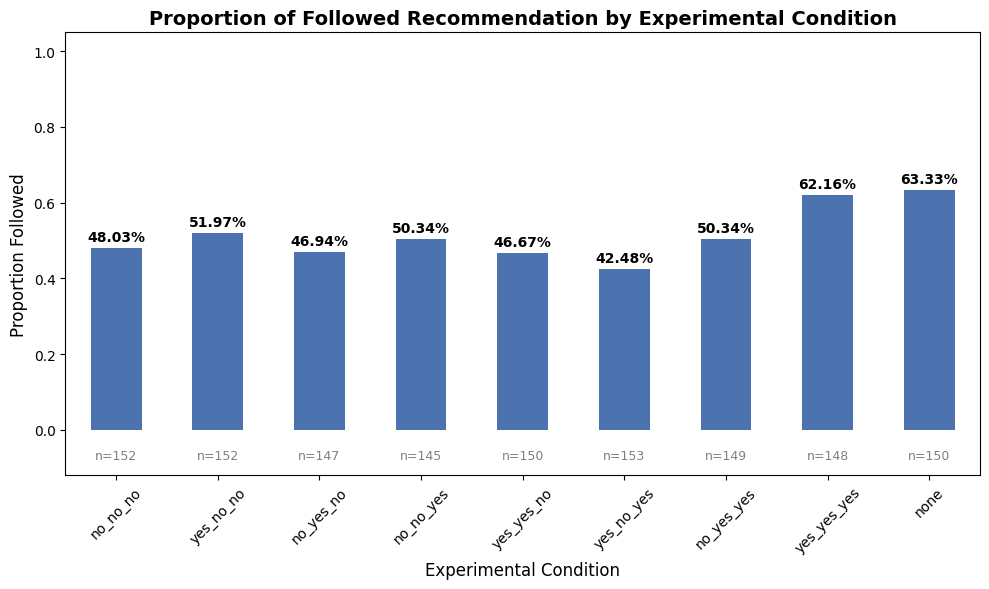

In [16]:
# =============================================================================
# 分析1：按实验条件(condition)分组分析
# =============================================================================

print("=== 分析1：按实验条件分组分析 ===")

# 指定condition的顺序以便可视化
condition_order = [
    'no_no_no', 'yes_no_no', 'no_yes_no', 'no_no_yes',
    'yes_yes_no', 'yes_no_yes', 'no_yes_yes', 'yes_yes_yes', 'none'
]

# 分组统计
cond_stats = df_clean.groupby('condition')['followed_recommendation'].agg(['mean', 'count', 'sum'])
cond_stats.rename(columns={'mean': 'Proportion Followed', 'count': 'Count', 'sum': 'Num Followed'}, inplace=True)
cond_stats = cond_stats.reindex(condition_order)

print("按condition分组的followed_recommendation统计:")
print(cond_stats)

# 可视化
fig, ax = plt.subplots(figsize=(10,6))
bars = cond_stats['Proportion Followed'].plot(kind='bar', ax=ax, color='#4C72B0')
ax.set_title('Proportion of Followed Recommendation by Experimental Condition', fontsize=14, fontweight='bold')
ax.set_xlabel('Experimental Condition', fontsize=12)
ax.set_ylabel('Proportion Followed', fontsize=12)
ax.set_xticklabels(condition_order, rotation=45)

# 添加数值标签
for i, (v, n) in enumerate(zip(cond_stats['Proportion Followed'], cond_stats['Count'])):
    if not pd.isna(v):
        ax.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom', fontweight='bold')
    if not pd.isna(n):
        ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=9, color='gray')

plt.ylim(-0.12, 1.05)
plt.tight_layout()
plt.show()

=== 分析1扩展：按实验条件和报告类型分组分析 ===

HR报告类型下按condition分组的followed_recommendation统计:
             Proportion Followed  Count  Num Followed
condition                                            
no_no_no                0.454545     77            35
yes_no_no               0.546667     75            41
no_yes_no               0.486111     72            35
no_no_yes               0.480000     75            36
yes_yes_no              0.480000     75            36
yes_no_yes              0.493506     77            38
no_yes_yes              0.533333     75            40
yes_yes_yes             0.631579     76            48
none                    0.610390     77            47

Med报告类型下按condition分组的followed_recommendation统计:
             Proportion Followed  Count  Num Followed
condition                                            
no_no_no                0.506667     75            38
yes_no_no               0.493506     77            38
no_yes_no               0.453333     75            34
no_no_yes 

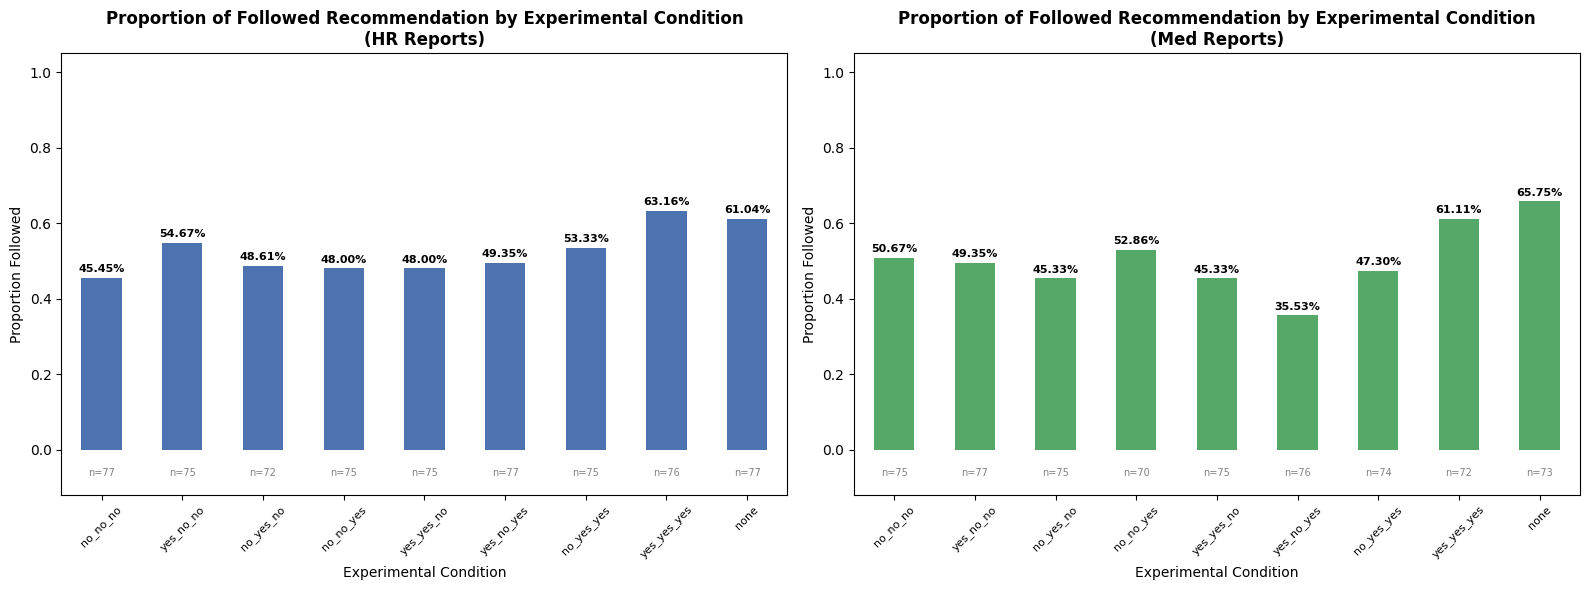

In [19]:
# =============================================================================
# 分析1扩展：按实验条件分组分析，按报告类型（report_type）分层
# =============================================================================

print("=== 分析1扩展：按实验条件和报告类型分组分析 ===")

# 定义condition的顺序以便可视化
condition_order = [
    'no_no_no', 'yes_no_no', 'no_yes_no', 'no_no_yes',
    'yes_yes_no', 'yes_no_yes', 'no_yes_yes', 'yes_yes_yes', 'none'
]

# 为HR和Med分别创建子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for i, report_type in enumerate(['HR', 'Med']):
    ax = ax1 if i == 0 else ax2
    
    # 筛选特定报告类型的数据
    df_report = df_clean[df_clean['report_type'] == report_type]
    
    # 分组统计
    cond_stats_report = df_report.groupby('condition')['followed_recommendation'].agg(['mean', 'count', 'sum'])
    cond_stats_report.rename(columns={'mean': 'Proportion Followed', 'count': 'Count', 'sum': 'Num Followed'}, inplace=True)
    cond_stats_report = cond_stats_report.reindex(condition_order)
    
    print(f"\n{report_type}报告类型下按condition分组的followed_recommendation统计:")
    print(cond_stats_report)
    
    # 可视化
    bars = cond_stats_report['Proportion Followed'].plot(kind='bar', ax=ax, color='#4C72B0' if i == 0 else '#55A868')
    ax.set_title(f'Proportion of Followed Recommendation by Experimental Condition\n({report_type} Reports)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Experimental Condition', fontsize=10)
    ax.set_ylabel('Proportion Followed', fontsize=10)
    ax.set_xticklabels(condition_order, rotation=45, fontsize=8)
    
    # 添加数值标签
    for j, (v, n) in enumerate(zip(cond_stats_report['Proportion Followed'], cond_stats_report['Count'])):
        if not pd.isna(v):
            ax.text(j, v + 0.01, f"{v:.2%}", ha='center', va='bottom', fontweight='bold', fontsize=8)
        if not pd.isna(n):
            ax.text(j, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=7, color='gray')
    
    ax.set_ylim(-0.12, 1.05)

plt.tight_layout()
plt.show()


In [ ]:
s

=== 分析2：按AI披露分组分析 ===
按AI披露分组的followed_recommendation统计:
                  Proportion Followed  Count  Num Followed
AI_disclosure                                             
No AI Disclosure             0.633333    150            95
AI Disclosure                0.498328   1196           596


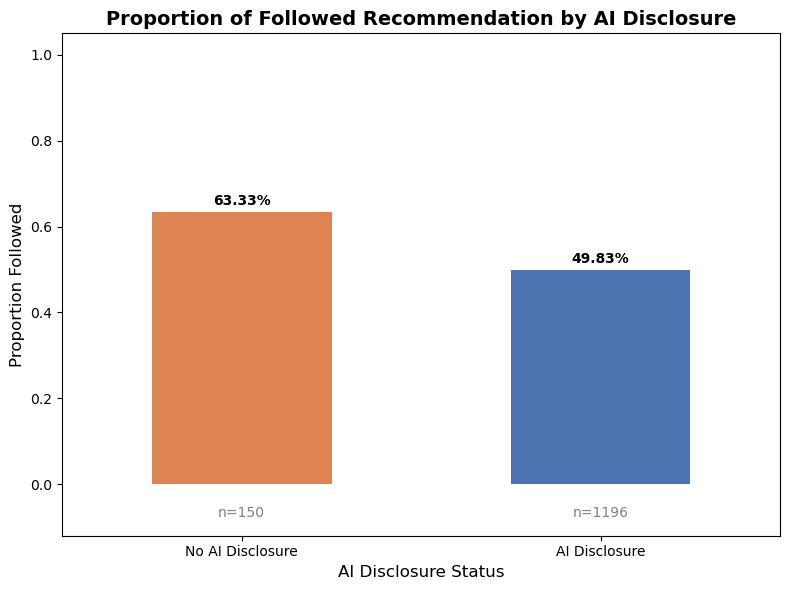

In [9]:
# =============================================================================
# 分析2：按AI披露分组分析
# =============================================================================

print("=== 分析2：按AI披露分组分析 ===")

ai_stats = df_clean.groupby('AI_disclosure')['followed_recommendation'].agg(['mean', 'count', 'sum'])
ai_stats.rename(columns={'mean': 'Proportion Followed', 'count': 'Count', 'sum': 'Num Followed'}, inplace=True)
ai_stats.index = ai_stats.index.map({True: 'AI Disclosure', False: 'No AI Disclosure'})

print("按AI披露分组的followed_recommendation统计:")
print(ai_stats)

fig, ax = plt.subplots(figsize=(8,6))
ai_stats['Proportion Followed'].plot(kind='bar', ax=ax, color=['#DD8452', '#4C72B0'])
ax.set_title('Proportion of Followed Recommendation by AI Disclosure', fontsize=14, fontweight='bold')
ax.set_xlabel('AI Disclosure Status', fontsize=12)
ax.set_ylabel('Proportion Followed', fontsize=12)
ax.set_xticklabels(ai_stats.index, rotation=0)

for i, (v, n) in enumerate(zip(ai_stats['Proportion Followed'], ai_stats['Count'])):
    ax.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom', fontweight='bold')
    ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=10, color='gray')

plt.ylim(-0.12, 1.05)
plt.tight_layout()
plt.show()

按照AI_disclosure分组的followed_recommendation统计：
                  Proportion Followed  Count  Num Followed
AI_disclosure                                             
No AI disclosure             0.633333    150            95
AI disclosure                0.498328   1196           596


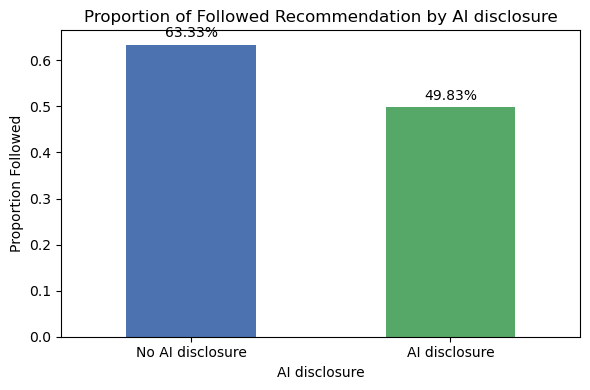

In [21]:
# 按照AI_disclosure分组统计followed_recommendation，并画图
ai_stats = df_long.groupby('AI_disclosure')['followed_recommendation'].agg(['mean', 'count', 'sum'])
ai_stats.rename(columns={'mean': 'Proportion Followed', 'count': 'Count', 'sum': 'Num Followed'}, inplace=True)
ai_stats.index = ai_stats.index.map({True: 'AI disclosure', False: 'No AI disclosure'})

print("按照AI_disclosure分组的followed_recommendation统计：")
print(ai_stats)

fig, ax = plt.subplots(figsize=(6,4))
ai_stats['Proportion Followed'].plot(kind='bar', ax=ax, color=['#4C72B0', '#55A868'])
ax.set_title('Proportion of Followed Recommendation by AI disclosure')
ax.set_xlabel('AI disclosure')
ax.set_ylabel('Proportion Followed')
ax.set_xticklabels(ai_stats.index, rotation=0)
for i, v in enumerate(ai_stats['Proportion Followed']):
    ax.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


按information（yes/no）分组的followed_recommendation统计：
             Proportion Followed  Count  Num Followed
information                                          
no                      0.489039    593           290
yes                     0.507463    603           306


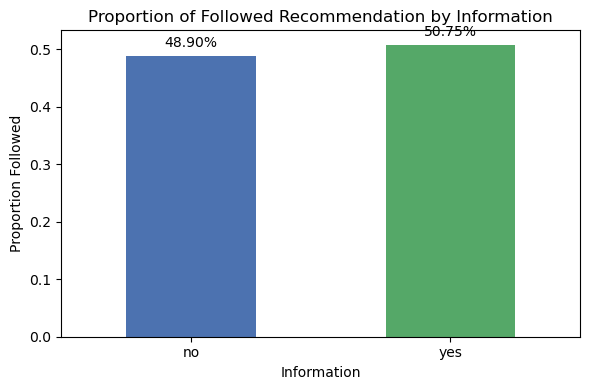

In [24]:
# 按照information（yes/no）分组统计followed_recommendation，并画图

# 直接用information字段（其值为"yes"或"no"）分组
info_stats = df_long.groupby('information')['followed_recommendation'].agg(['mean', 'count', 'sum'])
info_stats.rename_axis('information', inplace=True)
info_stats.rename(columns={'mean': 'Proportion Followed', 'count': 'Count', 'sum': 'Num Followed'}, inplace=True)

print("按information（yes/no）分组的followed_recommendation统计：")
print(info_stats)

# 绘图
fig, ax = plt.subplots(figsize=(6,4))
# 保证顺序为['no', 'yes']
plot_order = ['no', 'yes']
info_stats_plot = info_stats.reindex(plot_order)
info_stats_plot['Proportion Followed'].plot(kind='bar', ax=ax, color=['#4C72B0', '#55A868'])
ax.set_title('Proportion of Followed Recommendation by Information')
ax.set_xlabel('Information')
ax.set_ylabel('Proportion Followed')
ax.set_xticklabels(plot_order, rotation=0)
for i, v in enumerate(info_stats_plot['Proportion Followed']):
    if not pd.isna(v):
        ax.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


按analysis（yes/no）分组的followed_recommendation统计：
          Proportion Followed  Count  Num Followed
analysis                                          
no                   0.481728    602           290
yes                  0.515152    594           306


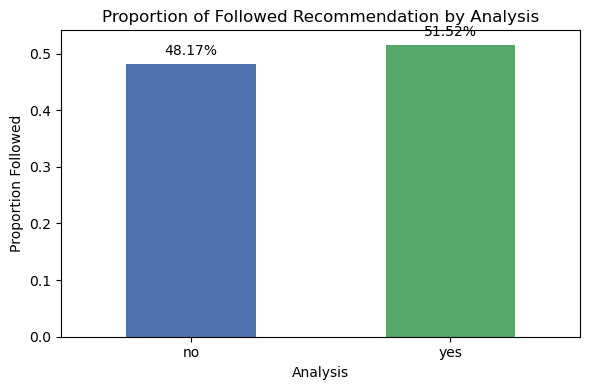

In [25]:
# 按照analysis（yes/no）分组统计followed_recommendation，并画图

# 统计
analysis_stats = df_long.groupby('analysis')['followed_recommendation'].agg(['mean', 'count', 'sum'])
analysis_stats.rename_axis('analysis', inplace=True)
analysis_stats.rename(columns={'mean': 'Proportion Followed', 'count': 'Count', 'sum': 'Num Followed'}, inplace=True)

print("按analysis（yes/no）分组的followed_recommendation统计：")
print(analysis_stats)

# 绘图
fig, ax = plt.subplots(figsize=(6,4))
# 保证顺序为['no', 'yes']
plot_order = ['no', 'yes']
analysis_stats_plot = analysis_stats.reindex(plot_order)
analysis_stats_plot['Proportion Followed'].plot(kind='bar', ax=ax, color=['#4C72B0', '#55A868'])
ax.set_title('Proportion of Followed Recommendation by Analysis')
ax.set_xlabel('Analysis')
ax.set_ylabel('Proportion Followed')
ax.set_xticklabels(plot_order, rotation=0)
for i, v in enumerate(analysis_stats_plot['Proportion Followed']):
    if not pd.isna(v):
        ax.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


按recommendation（yes/no）分组的followed_recommendation统计：
                Proportion Followed  Count  Num Followed
recommendation                                          
no                         0.484193    601           291
yes                        0.512605    595           305


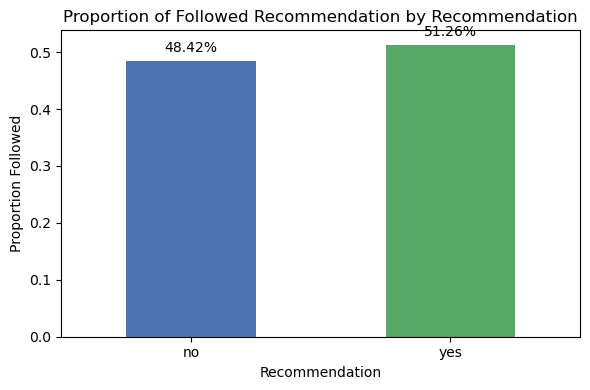

In [26]:

# 按照recommendation（yes/no）分组统计followed_recommendation，并画图

# 统计
recommendation_stats = df_long.groupby('recommendation')['followed_recommendation'].agg(['mean', 'count', 'sum'])
recommendation_stats.rename_axis('recommendation', inplace=True)
recommendation_stats.rename(columns={'mean': 'Proportion Followed', 'count': 'Count', 'sum': 'Num Followed'}, inplace=True)

print("按recommendation（yes/no）分组的followed_recommendation统计：")
print(recommendation_stats)

# 绘图
fig, ax = plt.subplots(figsize=(6,4))
# 保证顺序为['no', 'yes']
plot_order = ['no', 'yes']
recommendation_stats_plot = recommendation_stats.reindex(plot_order)
recommendation_stats_plot['Proportion Followed'].plot(kind='bar', ax=ax, color=['#4C72B0', '#55A868'])
ax.set_title('Proportion of Followed Recommendation by Recommendation')
ax.set_xlabel('Recommendation')
ax.set_ylabel('Proportion Followed')
ax.set_xticklabels(plot_order, rotation=0)
for i, v in enumerate(recommendation_stats_plot['Proportion Followed']):
    if not pd.isna(v):
        ax.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

按information（yes/no）分组的followed_recommendation统计：
             Proportion Followed  Count  Num Followed
information                                          
no                      0.633333    150            95
yes                     0.498328   1196           596


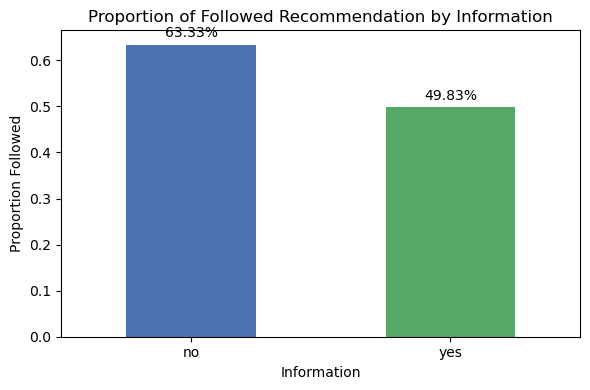

In [9]:
# 按照information的"yes"和"no"进行分组统计followed_recommendation
import matplotlib.pyplot as plt

# 先将information缺失/非缺失转为"no"/"yes"
df_long['information_group'] = df_long['information'].notna().map({True: 'yes', False: 'no'})

# 分组并计算统计量
group_stats = df_long.groupby('information_group')['followed_recommendation'].agg(['mean', 'count', 'sum'])
group_stats.rename_axis('information', inplace=True)
group_stats.rename(columns={'mean': 'Proportion Followed', 'count': 'Count', 'sum': 'Num Followed'}, inplace=True)

print("按information（yes/no）分组的followed_recommendation统计：")
print(group_stats)

# 绘图
fig, ax = plt.subplots(figsize=(6,4))
group_stats['Proportion Followed'].plot(kind='bar', ax=ax, color=['#4C72B0', '#55A868'])
ax.set_title('Proportion of Followed Recommendation by Information')
ax.set_xlabel('Information')
ax.set_ylabel('Proportion Followed')
ax.set_xticklabels(['no', 'yes'], rotation=0)
for i, v in enumerate(group_stats['Proportion Followed']):
    ax.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom')
plt.tight_layout()
plt.show()



Statistics of followed_recommendation by analysis group:
          Proportion Followed  Count  Num Followed
analysis                                          
no                   0.481728    602           290
yes                  0.515152    594           306


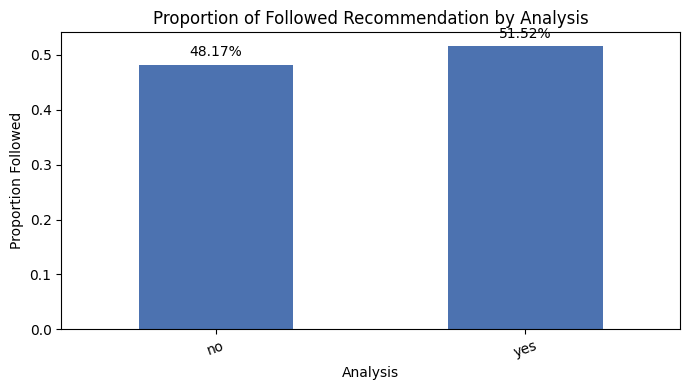

In [43]:
# Statistics of followed_recommendation by analysis group (in English)
analysis_stats = df_long.groupby('analysis')['followed_recommendation'].agg(['mean', 'count', 'sum'])
analysis_stats.rename(columns={'mean': 'Proportion Followed', 'count': 'Count', 'sum': 'Num Followed'}, inplace=True)

print("Statistics of followed_recommendation by analysis group:")
print(analysis_stats)

# Plot
fig, ax = plt.subplots(figsize=(7,4))
analysis_stats['Proportion Followed'].plot(kind='bar', ax=ax, color='#4C72B0')
ax.set_title('Proportion of Followed Recommendation by Analysis')
ax.set_xlabel('Analysis')
ax.set_ylabel('Proportion Followed')
ax.set_xticklabels(analysis_stats.index, rotation=20)
for i, v in enumerate(analysis_stats['Proportion Followed']):
    ax.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom')
plt.tight_layout()
plt.show()





Statistics of followed_recommendation by recommendation:
                Proportion Followed  Count  Num Followed
recommendation                                          
no                         0.484193    601           291
yes                        0.512605    595           305


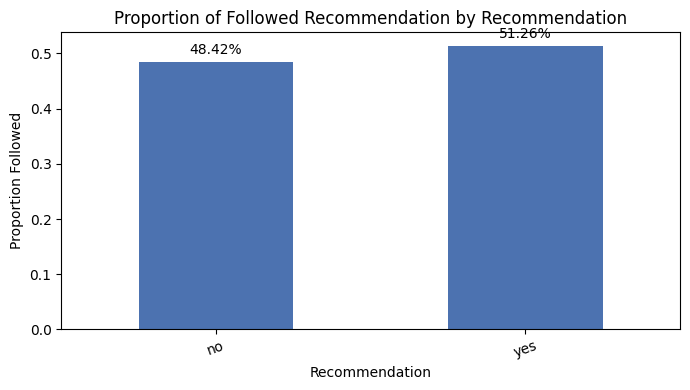

In [46]:
# 统计recommendation被followed的比例（按recommendation分组），并画图，label用英文
recommendation_stats = df_long.groupby('recommendation')['followed_recommendation'].agg(['mean', 'count', 'sum'])
recommendation_stats.rename(columns={'mean': 'Proportion Followed', 'count': 'Count', 'sum': 'Num Followed'}, inplace=True)

print("Statistics of followed_recommendation by recommendation:")
print(recommendation_stats)

# 绘图
fig, ax = plt.subplots(figsize=(7,4))
recommendation_stats['Proportion Followed'].plot(kind='bar', ax=ax, color='#4C72B0')
ax.set_title('Proportion of Followed Recommendation by Recommendation')
ax.set_xlabel('Recommendation')
ax.set_ylabel('Proportion Followed')
ax.set_xticklabels(recommendation_stats.index, rotation=20)
for i, v in enumerate(recommendation_stats['Proportion Followed']):
    ax.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


9组followed_recommendation统计:
                             Group  Proportion_Followed  Count  Num_Followed
0  Info:yes, Analysis:yes, Rec:yes             0.621622    148            92
1   Info:yes, Analysis:yes, Rec:no             0.466667    150            70
2   Info:yes, Analysis:no, Rec:yes             0.424837    153            65
3    Info:yes, Analysis:no, Rec:no             0.519737    152            79
4   Info:no, Analysis:yes, Rec:yes             0.503356    149            75
5    Info:no, Analysis:yes, Rec:no             0.469388    147            69
6    Info:no, Analysis:no, Rec:yes             0.503448    145            73
7     Info:no, Analysis:no, Rec:no             0.480263    152            73
8              AI_disclosure=False             0.633333    150            95


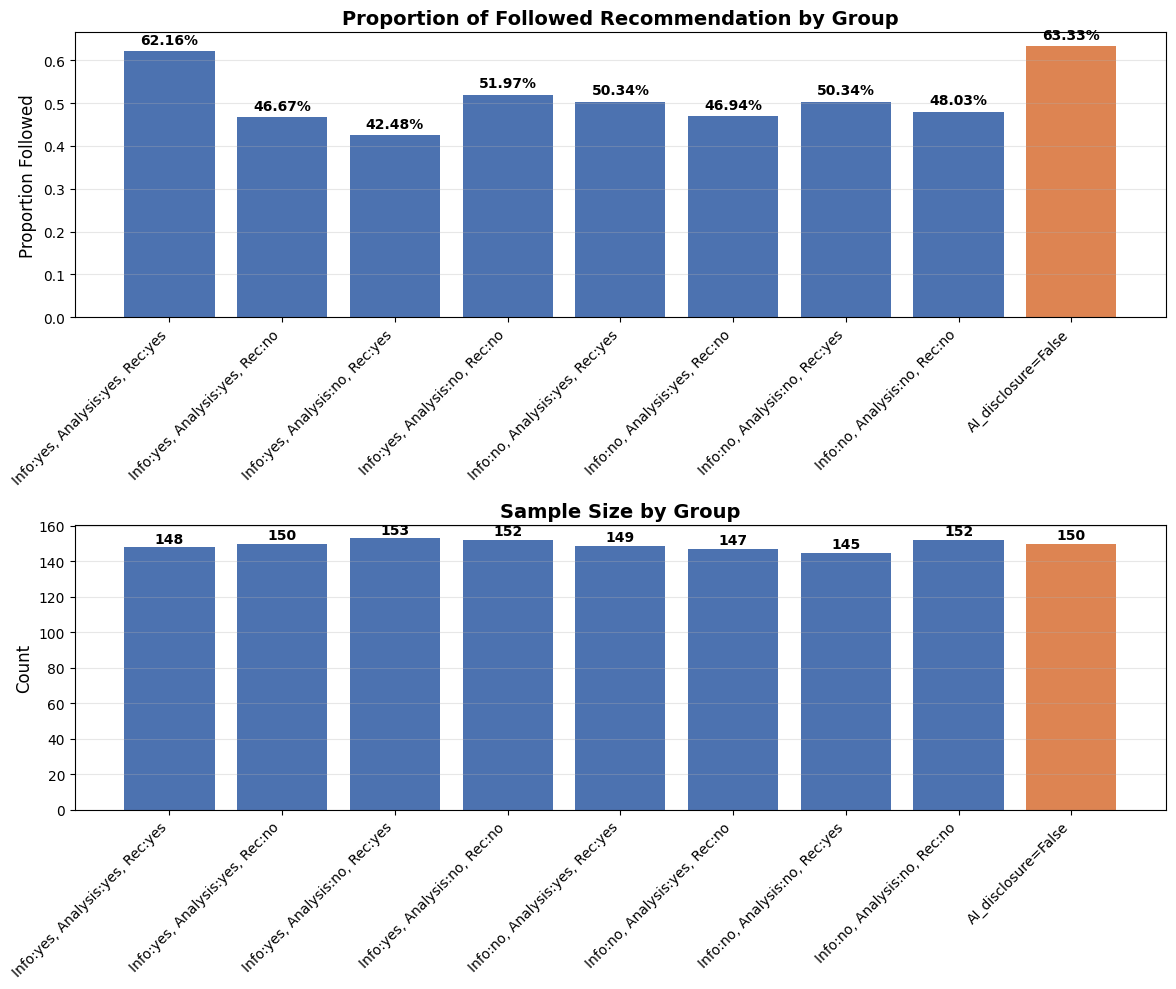

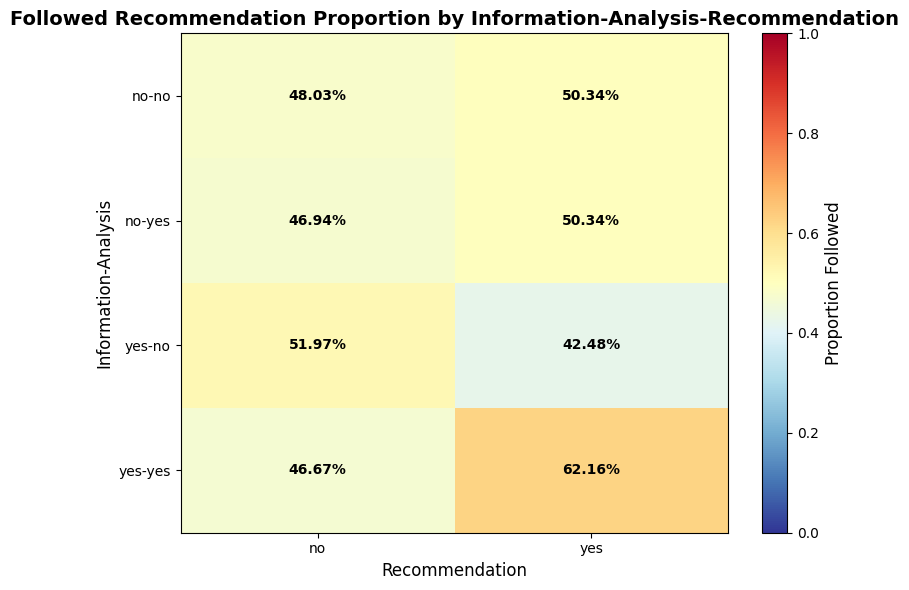

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# 读取数据
csv_path = Path("/Users/xingjianzhang/Library/CloudStorage/OneDrive-个人/rotman/MBH/MBH_main.csv")
df = pd.read_csv(csv_path, encoding="utf-8-sig")

# 筛选掉不需要的抬头行
df_filtered = df[
    (df['StartDate'] != "Start Date") & 
    (df['StartDate'] != '{"ImportId":"startDate","timeZone":"America/New_York"}')
].copy()

# 删除重复的Prolific ID
df_filtered = df_filtered[~df_filtered['Prolific ID'].isin(["643db5baa695a720a1bbdb4f", "6773a4f19e0b5c2d84f6a913"])]

# 识别实验变量
hr_vars = [col for col in df_filtered.columns if col.startswith('HR_')]
med_vars = [col for col in df_filtered.columns if col.startswith('Med_')]
experiment_vars = hr_vars + med_vars

# 宽转长
df_long = df_filtered.melt(
    id_vars=[col for col in df_filtered.columns if col not in experiment_vars],
    value_vars=experiment_vars,
    var_name='original_var',
    value_name='original_answer'
)

# 只保留非缺失的观测值
df_long = df_long[df_long['original_answer'].notna()].copy()
df_long.reset_index(drop=True, inplace=True)

# 拆分original_var
split_cols = df_long['original_var'].astype(str).str.split('_', n=4, expand=True)
split_cols.columns = ['report_type', 'source_type', 'information', 'analysis', 'recommendation']
df_long = pd.concat([df_long, split_cols], axis=1)

# 处理数据
df_long['AI_disclosure'] = (df_long['information'] != 'none')
df_long['recommendation'] = df_long['recommendation'].replace('ye', 'yes')
df_long['information'] = df_long['information'].replace('none', pd.NA)

# 生成followed_recommendation
df_long['followed_recommendation'] = df_long['original_answer'].isin(['Kinetic Workforce (KNTC)', 'Vista Therapeutics (VSTA)'])

# 生成9组的followed_recommendation统计
# 8组：information(yes/no) × analysis(yes/no) × recommendation(yes/no)
# 1组：AI_disclosure==False

# 创建组合条件
conditions = []

# 8组：information × analysis × recommendation
for info in ['yes', 'no']:
    for analysis in ['yes', 'no']:
        for rec in ['yes', 'no']:
            condition = (
                (df_long['information'] == info) & 
                (df_long['analysis'] == analysis) & 
                (df_long['recommendation'] == rec)
            )
            conditions.append({
                'name': f'Info:{info}, Analysis:{analysis}, Rec:{rec}',
                'condition': condition
            })

# 1组：AI_disclosure==False
conditions.append({
    'name': 'AI_disclosure=False',
    'condition': (df_long['AI_disclosure'] == False)
})

# 计算每组统计
results = []
for cond in conditions:
    subset = df_long[cond['condition']]
    if len(subset) > 0:
        mean_followed = subset['followed_recommendation'].mean()
        count = len(subset)
        num_followed = subset['followed_recommendation'].sum()
        results.append({
            'Group': cond['name'],
            'Proportion_Followed': mean_followed,
            'Count': count,
            'Num_Followed': num_followed
        })

# 转换为DataFrame
results_df = pd.DataFrame(results)
print("9组followed_recommendation统计:")
print(results_df)

# 画图展示
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 图1：比例图
bars1 = ax1.bar(range(len(results_df)), results_df['Proportion_Followed'], 
                color=['#4C72B0' if 'AI_disclosure=False' not in name else '#DD8452' for name in results_df['Group']])
ax1.set_title('Proportion of Followed Recommendation by Group', fontsize=14, fontweight='bold')
ax1.set_ylabel('Proportion Followed', fontsize=12)
ax1.set_xticks(range(len(results_df)))
ax1.set_xticklabels(results_df['Group'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# 添加数值标签
for i, (bar, prop) in enumerate(zip(bars1, results_df['Proportion_Followed'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f"{prop:.2%}", ha='center', va='bottom', fontweight='bold')

# 图2：样本量图
bars2 = ax2.bar(range(len(results_df)), results_df['Count'], 
                color=['#4C72B0' if 'AI_disclosure=False' not in name else '#DD8452' for name in results_df['Group']])
ax2.set_title('Sample Size by Group', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xticks(range(len(results_df)))
ax2.set_xticklabels(results_df['Group'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# 添加数值标签
for i, (bar, count) in enumerate(zip(bars2, results_df['Count'])):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f"{count}", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 额外：创建热力图展示8组组合（排除AI_disclosure=False）
combo_results = results_df[~results_df['Group'].str.contains('AI_disclosure')].copy()

# 提取条件值
combo_results['Info'] = combo_results['Group'].str.extract(r'Info:(\w+)')
combo_results['Analysis'] = combo_results['Group'].str.extract(r'Analysis:(\w+)')
combo_results['Rec'] = combo_results['Group'].str.extract(r'Rec:(\w+)')

# 创建透视表
pivot_table = combo_results.pivot_table(
    values='Proportion_Followed', 
    index=['Info', 'Analysis'], 
    columns='Rec', 
    aggfunc='first'
)

# 画热力图
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(pivot_table.values, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)

# 设置标签
ax.set_xticks(range(len(pivot_table.columns)))
ax.set_yticks(range(len(pivot_table.index)))
ax.set_xticklabels(pivot_table.columns)
ax.set_yticklabels([f"{idx[0]}-{idx[1]}" for idx in pivot_table.index])

# 添加数值标签
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        text = ax.text(j, i, f"{pivot_table.iloc[i, j]:.2%}", 
                      ha="center", va="center", color="black", fontweight='bold')

ax.set_title('Followed Recommendation Proportion by Information-Analysis-Recommendation', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Recommendation', fontsize=12)
ax.set_ylabel('Information-Analysis', fontsize=12)

# 添加颜色条
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Proportion Followed', fontsize=12)

plt.tight_layout()
plt.show()


In [13]:
# pyfixest 回归分析
# 只保留条件为 "no_no_no" 和 "yes_yes_yes" 的数据
# 因变量: followed_recommendation
# 自变量: 条件是否为 "yes_yes_yes"
# 运行回归

import pyfixest as pf

# 筛选数据：只保留 "no_no_no" 和 "yes_yes_yes" 条件
regression_data = df_clean[df_clean['condition'].isin(['no_no_no', 'yes_yes_yes'])].copy()

# 创建虚拟变量：yes_yes_yes = 1，no_no_no = 0
regression_data['treatment'] = (regression_data['condition'] == 'yes_yes_yes').astype(int)

print(f"回归分析数据样本量: {len(regression_data)}")
print(f"yes_yes_yes 组样本量: {len(regression_data[regression_data['treatment'] == 1])}")
print(f"no_no_no 组样本量: {len(regression_data[regression_data['treatment'] == 0])}")

# 运行简单线性回归
model = pf.feols("followed_recommendation ~ treatment", data=regression_data)
print("\n回归结果:")
print(model.summary())

# 添加控制变量的回归（如果有其他变量）
# model_with_controls = pf.feols("followed_recommendation ~ treatment + C(AnalystName)", data=regression_data)
# print("\n包含分析师固定效应的回归结果:")
# print(model_with_controls.summary())


回归分析数据样本量: 300
yes_yes_yes 组样本量: 148
no_no_no 组样本量: 152

回归结果:
###

Estimation:  OLS
Dep. var.: followed_recommendation, Fixed effects: 0
Inference:  iid
Observations:  300

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.480 |        0.040 |    11.984 |      0.000 |  0.401 |   0.559 |
| treatment     |      0.141 |        0.057 |     2.477 |      0.014 |  0.029 |   0.254 |
---
RMSE: 0.492 R2: 0.02 
None


In [ ]:
# pyfixest 回归分析
# 只保留条件为 "no_no_no" 和 "yes_yes_yes" 的数据
# 因变量: followed_recommendation
# 自变量: 条件是否为 "yes_yes_yes"
# 运行回归

import pyfixest as pf

# 筛选数据：只保留 "no_no_no" 和 "none" 条件
regression_data = df_clean[df_clean['condition'].isin(['no_no_no', 'none'])].copy()

# 创建虚拟变量：yes_yes_yes = 1，no_no_no = 0
regression_data['treatment'] = (regression_data['condition'] == 'none').astype(int)

print(f"回归分析数据样本量: {len(regression_data)}")
print(f"yes_yes_yes 组样本量: {len(regression_data[regression_data['treatment'] == 1])}")
print(f"no_no_no 组样本量: {len(regression_data[regression_data['treatment'] == 0])}")

# 运行简单线性回归
model = pf.feols("followed_recommendation ~ treatment", data=regression_data)
print("\n回归结果:")
print(model.summary())

# 添加控制变量的回归（如果有其他变量）
# model_with_controls = pf.feols("followed_recommendation ~ treatment + C(AnalystName)", data=regression_data)
# print("\n包含分析师固定效应的回归结果:")
# print(model_with_controls.summary())


回归分析数据样本量: 302
yes_yes_yes 组样本量: 150
no_no_no 组样本量: 152

回归结果:
###

Estimation:  OLS
Dep. var.: followed_recommendation, Fixed effects: 0
Inference:  iid
Observations:  302

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.456 |        0.042 |    10.740 |      0.000 |  0.372 |   0.539 |
| treatment     |      0.159 |        0.057 |     2.800 |      0.005 |  0.047 |   0.270 |
| duration      |      0.000 |        0.000 |     1.677 |      0.095 | -0.000 |   0.000 |
---
RMSE: 0.489 R2: 0.033 
None


=== 分析1：按实验条件分组分析 ===
按condition分组的Time of preparation_1统计:
             Mean preparation_time  Count  Total preparation_time
condition                                                        
no_no_no                  5.348684    152                     813
yes_no_no                 4.934211    152                     750
no_yes_no                      5.0    147                     735
no_no_yes                 5.317241    145                     771
yes_yes_no                     4.7    150                     705
yes_no_yes                4.901961    153                     750
no_yes_yes                4.744966    149                     707
yes_yes_yes               4.554054    148                     674
none                      5.326667    150                     799


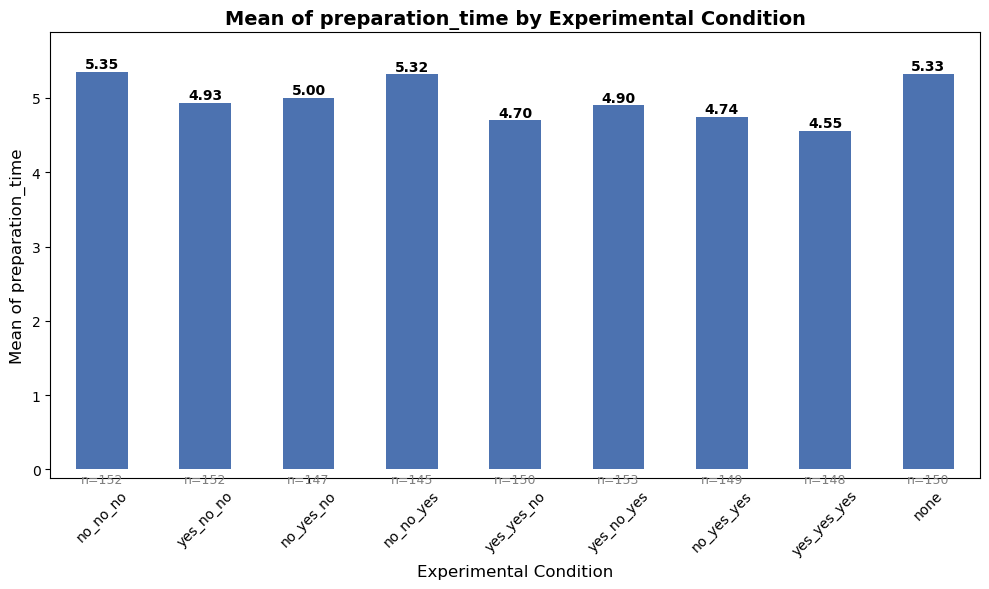

In [19]:
# =============================================================================
# 分析1：按实验条件(condition)分组分析
# =============================================================================

print("=== 分析1：按实验条件分组分析 ===")

# 指定condition的顺序以便可视化
condition_order = [
    'no_no_no', 'yes_no_no', 'no_yes_no', 'no_no_yes',
    'yes_yes_no', 'yes_no_yes', 'no_yes_yes', 'yes_yes_yes', 'none'
]

# 分组统计
cond_stats = df_clean.groupby('condition')['preparation_time'].agg(['mean', 'count', 'sum'])
cond_stats.rename(columns={'mean': 'Mean preparation_time', 'count': 'Count', 'sum': 'Total preparation_time'}, inplace=True)
cond_stats = cond_stats.reindex(condition_order)

print("按condition分组的Time of preparation_1统计:")
print(cond_stats)

# 可视化
fig, ax = plt.subplots(figsize=(10,6))
bars = cond_stats['Mean preparation_time'].plot(kind='bar', ax=ax, color='#4C72B0')
ax.set_title('Mean of preparation_time by Experimental Condition', fontsize=14, fontweight='bold')
ax.set_xlabel('Experimental Condition', fontsize=12)
ax.set_ylabel('Mean of preparation_time', fontsize=12)
ax.set_xticklabels(condition_order, rotation=45)

# 添加数值标签
for i, (v, n) in enumerate(zip(cond_stats['Mean preparation_time'], cond_stats['Count'])):
    if not pd.isna(v):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
    if not pd.isna(n):
        ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=9, color='gray')

plt.ylim(-0.12, cond_stats['Mean preparation_time'].max() * 1.1 if not pd.isna(cond_stats['Mean preparation_time'].max()) else 1.05)
plt.tight_layout()
plt.show()

=== 分析1：按实验条件分组分析 ===
按condition分组的Effort_1统计:
             Mean Effort  Count  Total Effort
condition                                    
no_no_no        5.546053    152           843
yes_no_no       5.078947    152           772
no_yes_no       5.197279    147           764
no_no_yes       5.289655    145           767
yes_yes_no      4.966667    150           745
yes_no_yes      5.130719    153           785
no_yes_yes      4.919463    149           733
yes_yes_yes     4.763514    148           705
none            5.426667    150           814


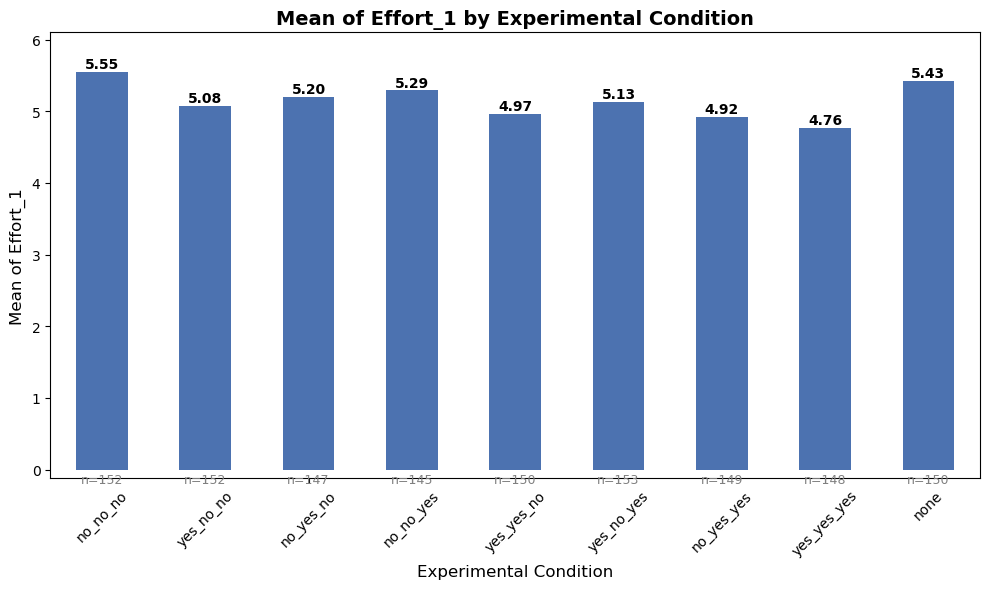

In [ ]:
# =============================================================================
# 分析1：按实验条件(condition)分组分析
# =============================================================================

print("=== 分析1：按实验条件分组分析 ===")

# 指定condition的顺序以便可视化
condition_order = [
    'no_no_no', 'yes_no_no', 'no_yes_no', 'no_no_yes',
    'yes_yes_no', 'yes_no_yes', 'no_yes_yes', 'yes_yes_yes', 'none'
]

# 分组统计
cond_stats = df_clean.groupby('condition')['Effort_1'].agg(['mean', 'count', 'sum'])
cond_stats.rename(columns={'mean': 'Mean Effort', 'count': 'Count', 'sum': 'Total Effort'}, inplace=True)
cond_stats = cond_stats.reindex(condition_order)

print("按condition分组的Effort_1统计:")
print(cond_stats)

# 可视化
fig, ax = plt.subplots(figsize=(10,6))
bars = cond_stats['Mean Effort'].plot(kind='bar', ax=ax, color='#4C72B0')
ax.set_title('Mean of Effort by Experimental Condition', fontsize=14, fontweight='bold')
ax.set_xlabel('Experimental Condition', fontsize=12)
ax.set_ylabel('Mean of Effort', fontsize=12)
ax.set_xticklabels(condition_order, rotation=45)

# 添加数值标签
for i, (v, n) in enumerate(zip(cond_stats['Mean Effort'], cond_stats['Count'])):
    if not pd.isna(v):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
    if not pd.isna(n):
        ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=9, color='gray')

plt.ylim(-0.12, cond_stats['Mean Effort'].max() * 1.1 if not pd.isna(cond_stats['Mean Effort'].max()) else 1.05)
plt.tight_layout()
plt.show()

=== 分析2：按实验条件分组分析 originality_1 ===
按condition分组的originality_1统计:
             Mean originality_1  Count  Total originality_1
condition                                                  
no_no_no               4.789474    152                  728
yes_no_no              4.763158    152                  724
no_yes_no              4.748299    147                  698
no_no_yes              5.075862    145                  736
yes_yes_no                  4.7    150                  705
yes_no_yes             4.738562    153                  725
no_yes_yes              4.66443    149                  695
yes_yes_yes            4.635135    148                  686
none                   5.033333    150                  755


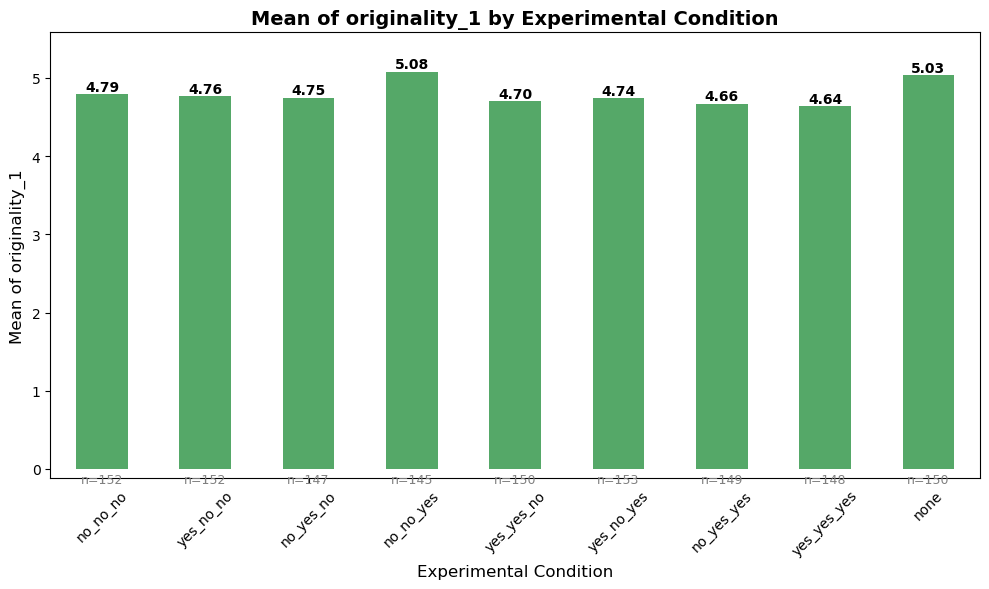

=== 分析3：按实验条件分组分析 originality_2 ===
按condition分组的originality_2统计:
             Mean originality_2  Count  Total originality_2
condition                                                  
no_no_no               3.697368    152                  562
yes_no_no              3.664474    152                  557
no_yes_no              3.714286    147                  546
no_no_yes              3.765517    145                  546
yes_yes_no                 3.54    150                  531
yes_no_yes              3.72549    153                  570
no_yes_yes             3.557047    149                  530
yes_yes_yes            3.709459    148                  549
none                   3.613333    150                  542


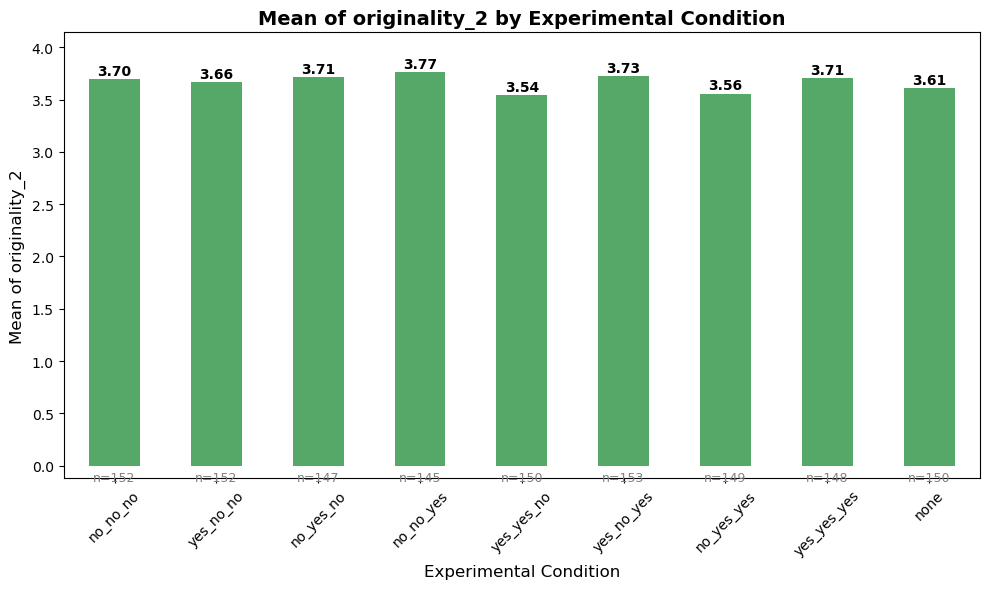

=== 分析4：按实验条件分组分析 originality_3 ===
按condition分组的originality_3统计:
             Mean originality_3  Count  Total originality_3
condition                                                  
no_no_no               3.368421    152                  512
yes_no_no              3.572368    152                  543
no_yes_no              3.408163    147                  501
no_no_yes               3.42069    145                  496
yes_yes_no             3.673333    150                  551
yes_no_yes              3.51634    153                  538
no_yes_yes             3.422819    149                  510
yes_yes_yes            3.601351    148                  533
none                   3.346667    150                  502


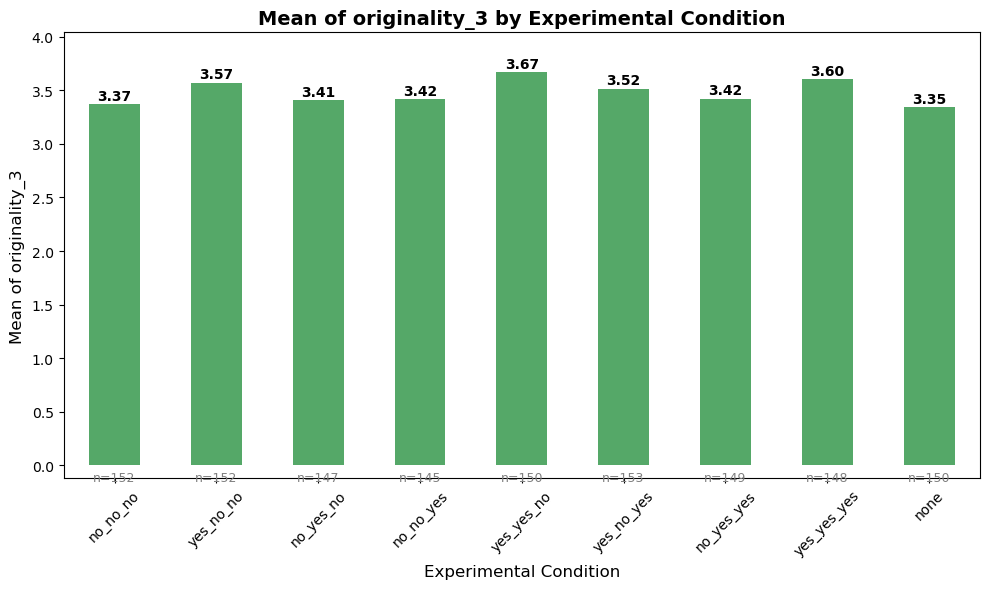

=== 分析5：按实验条件分组分析 originality_4 ===
按condition分组的originality_4统计:
             Mean originality_4  Count  Total originality_4
condition                                                  
no_no_no               2.980263    152                  453
yes_no_no              3.059211    152                  465
no_yes_no              2.986395    147                  439
no_no_yes              3.048276    145                  442
yes_yes_no                 3.08    150                  462
yes_no_yes             2.928105    153                  448
no_yes_yes             3.033557    149                  452
yes_yes_yes            3.148649    148                  466
none                   2.973333    150                  446


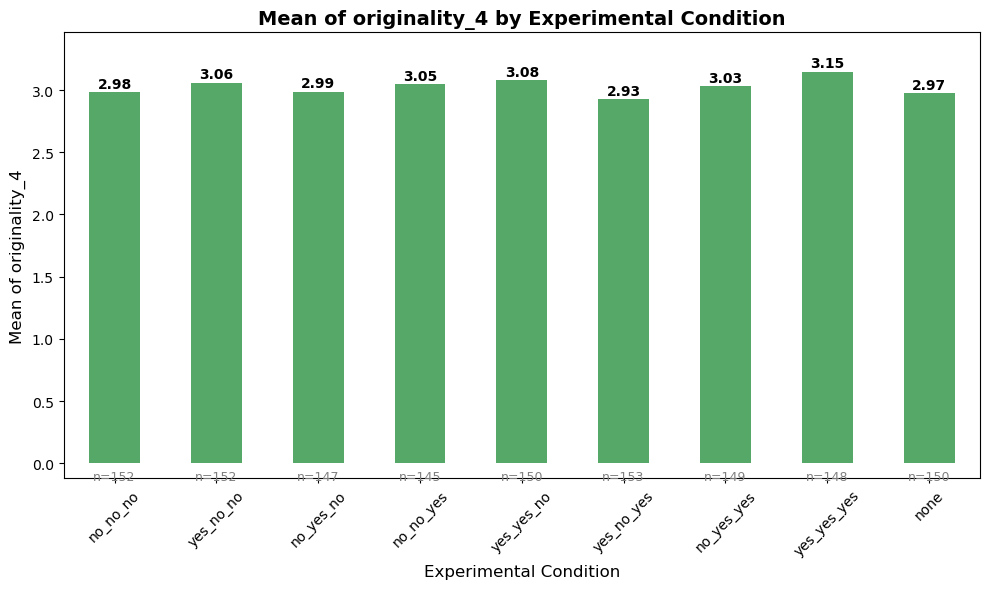

=== 分析6：按实验条件分组分析 originality_mean ===
按condition分组的originality_mean统计:
             Mean originality_mean  Count  Total originality_mean
condition                                                        
no_no_no                  3.708882    152                  563.75
yes_no_no                 3.764803    152                  572.25
no_yes_no                 3.714286    147                   546.0
no_no_yes                 3.827586    145                   555.0
yes_yes_no                3.748333    150                  562.25
yes_no_yes                3.727124    153                  570.25
no_yes_yes                3.669463    149                  546.75
yes_yes_yes               3.773649    148                   558.5
none                      3.741667    150                  561.25


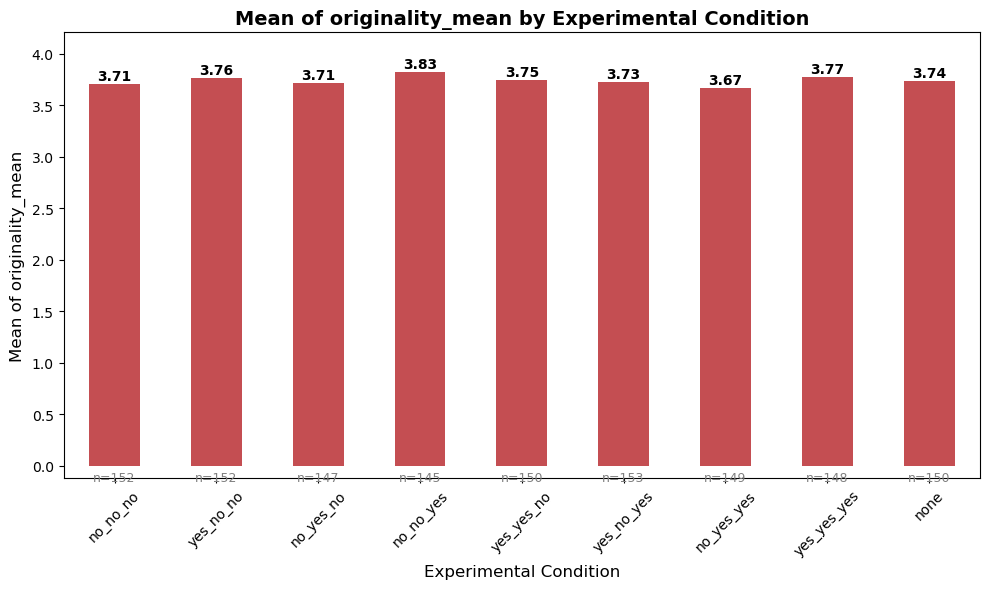

In [22]:
# 生成originality_1, originality_2, originality_3, originality_4的分组统计和可视化，以及它们均值的分组统计和可视化

originality_vars = ['originality_1', 'originality_2', 'originality_3', 'originality_4']

for idx, var in enumerate(originality_vars, 1):
    print(f"=== 分析{idx+1}：按实验条件分组分析 {var} ===")
    cond_stats_ori = df_clean.groupby('condition')[var].agg(['mean', 'count', 'sum'])
    cond_stats_ori.rename(columns={'mean': f'Mean {var}', 'count': 'Count', 'sum': f'Total {var}'}, inplace=True)
    cond_stats_ori = cond_stats_ori.reindex(condition_order)
    print(f"按condition分组的{var}统计:")
    print(cond_stats_ori)

    fig, ax = plt.subplots(figsize=(10,6))
    bars = cond_stats_ori[f'Mean {var}'].plot(kind='bar', ax=ax, color='#55A868')
    ax.set_title(f'Mean of {var} by Experimental Condition', fontsize=14, fontweight='bold')
    ax.set_xlabel('Experimental Condition', fontsize=12)
    ax.set_ylabel(f'Mean of {var}', fontsize=12)
    ax.set_xticklabels(condition_order, rotation=45)

    # 添加数值标签
    for i, (v, n) in enumerate(zip(cond_stats_ori[f'Mean {var}'], cond_stats_ori['Count'])):
        if not pd.isna(v):
            ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
        if not pd.isna(n):
            ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=9, color='gray')

    plt.ylim(-0.12, cond_stats_ori[f'Mean {var}'].max() * 1.1 if not pd.isna(cond_stats_ori[f'Mean {var}'].max()) else 1.05)
    plt.tight_layout()
    plt.show()

# 计算originality均值
df_clean['originality_mean'] = df_clean[originality_vars].mean(axis=1)

print("=== 分析6：按实验条件分组分析 originality_mean ===")
cond_stats_ori_mean = df_clean.groupby('condition')['originality_mean'].agg(['mean', 'count', 'sum'])
cond_stats_ori_mean.rename(columns={'mean': 'Mean originality_mean', 'count': 'Count', 'sum': 'Total originality_mean'}, inplace=True)
cond_stats_ori_mean = cond_stats_ori_mean.reindex(condition_order)
print("按condition分组的originality_mean统计:")
print(cond_stats_ori_mean)

fig, ax = plt.subplots(figsize=(10,6))
bars = cond_stats_ori_mean['Mean originality_mean'].plot(kind='bar', ax=ax, color='#C44E52')
ax.set_title('Mean of originality_mean by Experimental Condition', fontsize=14, fontweight='bold')
ax.set_xlabel('Experimental Condition', fontsize=12)
ax.set_ylabel('Mean of originality_mean', fontsize=12)
ax.set_xticklabels(condition_order, rotation=45)

# 添加数值标签
for i, (v, n) in enumerate(zip(cond_stats_ori_mean['Mean originality_mean'], cond_stats_ori_mean['Count'])):
    if not pd.isna(v):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
    if not pd.isna(n):
        ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=9, color='gray')

plt.ylim(-0.12, cond_stats_ori_mean['Mean originality_mean'].max() * 1.1 if not pd.isna(cond_stats_ori_mean['Mean originality_mean'].max()) else 1.05)
plt.tight_layout()
plt.show()




=== 分析2：按实验条件分组分析 accountability_1 ===
按condition分组的accountability_1统计:
             Mean accountability_1  Count  Total accountability_1
condition                                                        
no_no_no                     4.125    152                     627
yes_no_no                 4.059211    152                     617
no_yes_no                 4.163265    147                     612
no_no_yes                 4.117241    145                     597
yes_yes_no                4.153333    150                     623
yes_no_yes                4.183007    153                     640
no_yes_yes                4.040268    149                     602
yes_yes_yes               3.945946    148                     584
none                      4.193333    150                     629


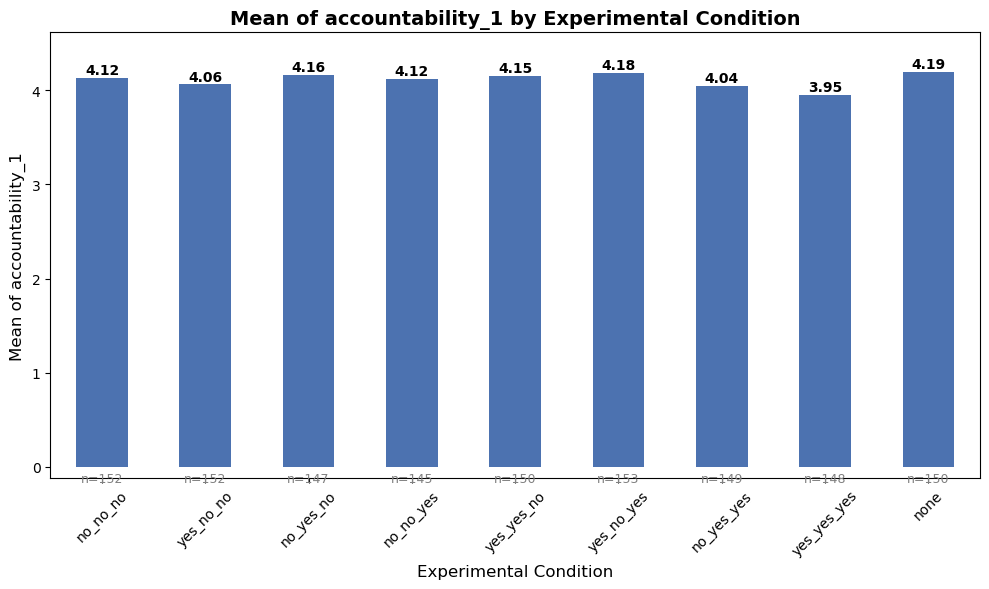

=== 分析3：按实验条件分组分析 accountability_2 ===
按condition分组的accountability_2统计:
             Mean accountability_2  Count  Total accountability_2
condition                                                        
no_no_no                  4.480263    152                     681
yes_no_no                 4.388158    152                     667
no_yes_no                 4.272109    147                     628
no_no_yes                 4.344828    145                     630
yes_yes_no                4.186667    150                     628
yes_no_yes                4.254902    153                     651
no_yes_yes                4.060403    149                     605
yes_yes_yes               4.175676    148                     618
none                      4.533333    150                     680


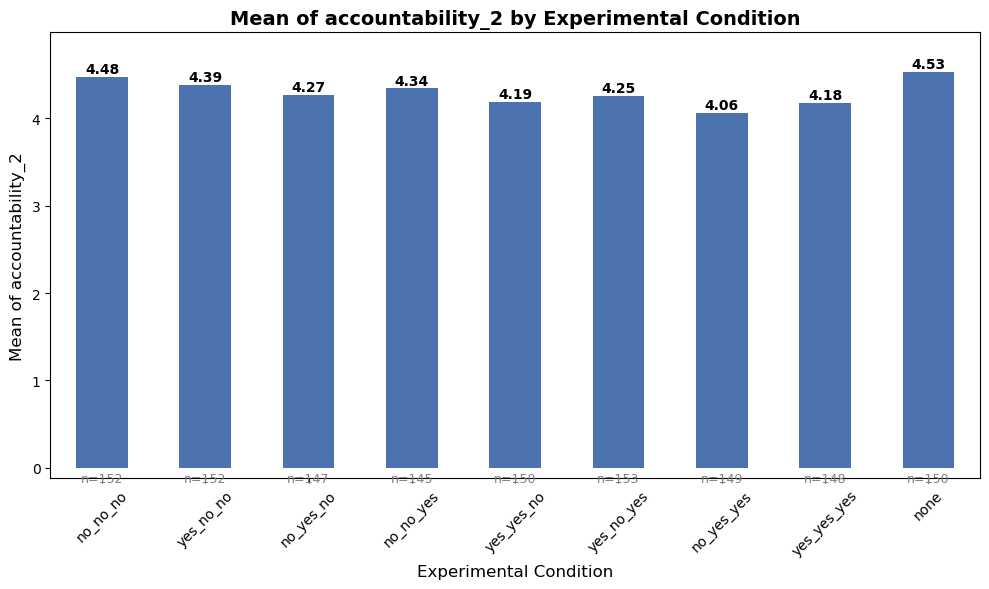

=== 分析4：按实验条件分组分析 accountability_3 ===
按condition分组的accountability_3统计:
             Mean accountability_3  Count  Total accountability_3
condition                                                        
no_no_no                  4.388158    152                     667
yes_no_no                 4.289474    152                     652
no_yes_no                 4.394558    147                     646
no_no_yes                  4.17931    145                     606
yes_yes_no                4.306667    150                     646
yes_no_yes                4.039216    153                     618
no_yes_yes                4.127517    149                     615
yes_yes_yes               4.087838    148                     605
none                      4.353333    150                     653


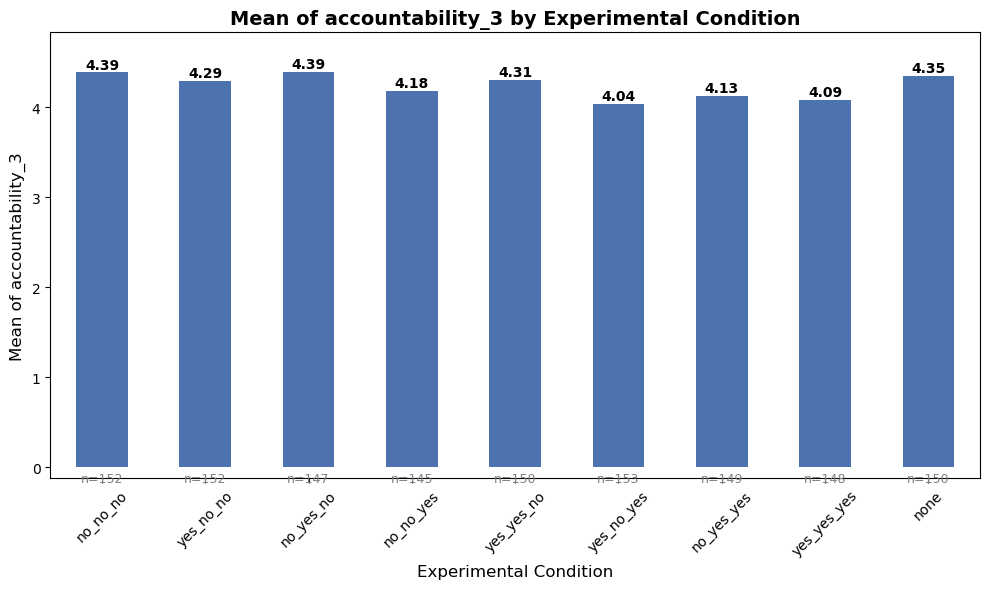

=== 分析5：按实验条件分组分析 accountability_4 ===
按condition分组的accountability_4统计:
             Mean accountability_4  Count  Total accountability_4
condition                                                        
no_no_no                  4.546053    152                     691
yes_no_no                 4.046053    152                     615
no_yes_no                 4.360544    147                     641
no_no_yes                 4.096552    145                     594
yes_yes_no                4.213333    150                     632
yes_no_yes                4.189542    153                     641
no_yes_yes                4.147651    149                     618
yes_yes_yes               3.959459    148                     586
none                      4.353333    150                     653


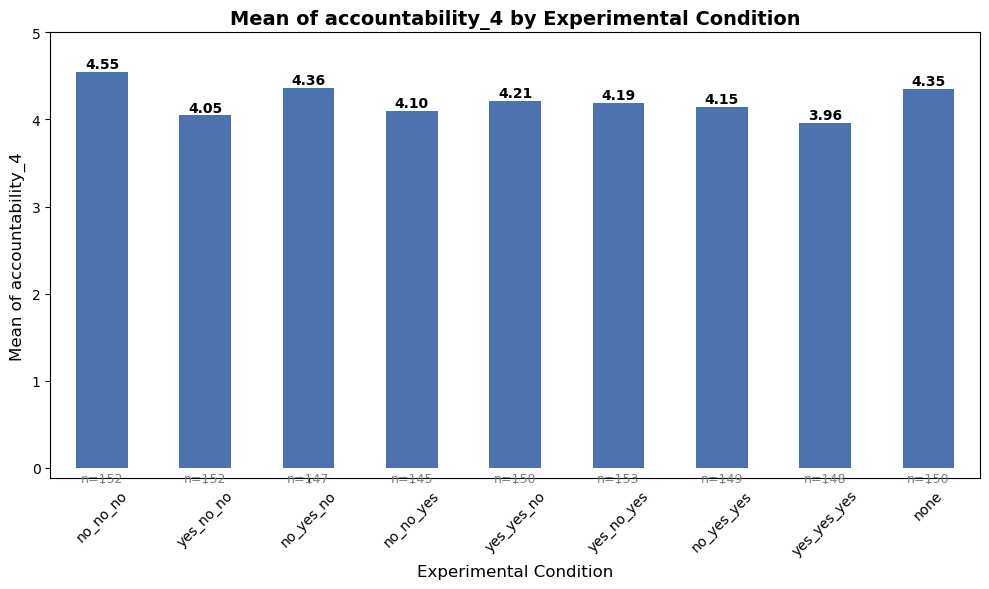

=== 分析6：按实验条件分组分析 accountability_mean ===
按condition分组的accountability_mean统计:
             Mean accountability_mean  Count  Total accountability_mean
condition                                                              
no_no_no                     4.384868    152                      666.5
yes_no_no                    4.195724    152                     637.75
no_yes_no                    4.297619    147                     631.75
no_no_yes                    4.184483    145                     606.75
yes_yes_no                      4.215    150                     632.25
yes_no_yes                   4.166667    153                      637.5
no_yes_yes                    4.09396    149                      610.0
yes_yes_yes                   4.04223    148                     598.25
none                         4.358333    150                     653.75


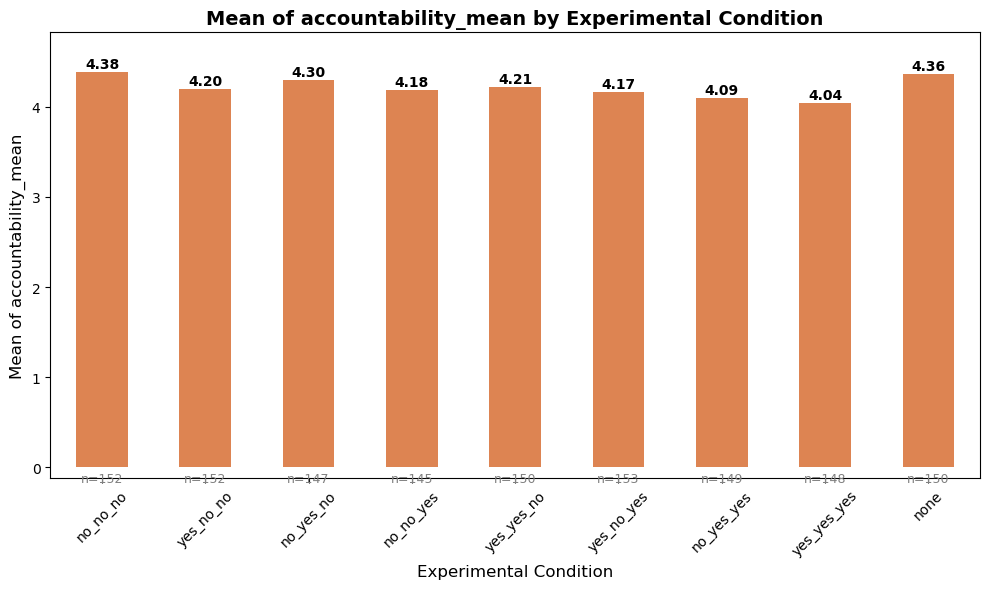

In [23]:
# 生成accountability_1, accountability_2, accountability_3, accountability_4的分组统计和可视化，以及它们均值的分组统计和可视化

accountability_vars = ['accountability_1', 'accountability_2', 'accountability_3', 'accountability_4']

for idx, var in enumerate(accountability_vars, 1):
    print(f"=== 分析{idx+1}：按实验条件分组分析 {var} ===")
    cond_stats_acc = df_clean.groupby('condition')[var].agg(['mean', 'count', 'sum'])
    cond_stats_acc.rename(columns={'mean': f'Mean {var}', 'count': 'Count', 'sum': f'Total {var}'}, inplace=True)
    cond_stats_acc = cond_stats_acc.reindex(condition_order)
    print(f"按condition分组的{var}统计:")
    print(cond_stats_acc)

    fig, ax = plt.subplots(figsize=(10,6))
    bars = cond_stats_acc[f'Mean {var}'].plot(kind='bar', ax=ax, color='#4C72B0')
    ax.set_title(f'Mean of {var} by Experimental Condition', fontsize=14, fontweight='bold')
    ax.set_xlabel('Experimental Condition', fontsize=12)
    ax.set_ylabel(f'Mean of {var}', fontsize=12)
    ax.set_xticklabels(condition_order, rotation=45)

    # 添加数值标签
    for i, (v, n) in enumerate(zip(cond_stats_acc[f'Mean {var}'], cond_stats_acc['Count'])):
        if not pd.isna(v):
            ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
        if not pd.isna(n):
            ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=9, color='gray')

    plt.ylim(-0.12, cond_stats_acc[f'Mean {var}'].max() * 1.1 if not pd.isna(cond_stats_acc[f'Mean {var}'].max()) else 1.05)
    plt.tight_layout()
    plt.show()

# 计算accountability均值
df_clean['accountability_mean'] = df_clean[accountability_vars].mean(axis=1)

print("=== 分析6：按实验条件分组分析 accountability_mean ===")
cond_stats_acc_mean = df_clean.groupby('condition')['accountability_mean'].agg(['mean', 'count', 'sum'])
cond_stats_acc_mean.rename(columns={'mean': 'Mean accountability_mean', 'count': 'Count', 'sum': 'Total accountability_mean'}, inplace=True)
cond_stats_acc_mean = cond_stats_acc_mean.reindex(condition_order)
print("按condition分组的accountability_mean统计:")
print(cond_stats_acc_mean)

fig, ax = plt.subplots(figsize=(10,6))
bars = cond_stats_acc_mean['Mean accountability_mean'].plot(kind='bar', ax=ax, color='#DD8452')
ax.set_title('Mean of accountability_mean by Experimental Condition', fontsize=14, fontweight='bold')
ax.set_xlabel('Experimental Condition', fontsize=12)
ax.set_ylabel('Mean of accountability_mean', fontsize=12)
ax.set_xticklabels(condition_order, rotation=45)

# 添加数值标签
for i, (v, n) in enumerate(zip(cond_stats_acc_mean['Mean accountability_mean'], cond_stats_acc_mean['Count'])):
    if not pd.isna(v):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
    if not pd.isna(n):
        ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=9, color='gray')

plt.ylim(-0.12, cond_stats_acc_mean['Mean accountability_mean'].max() * 1.1 if not pd.isna(cond_stats_acc_mean['Mean accountability_mean'].max()) else 1.05)
plt.tight_layout()
plt.show()


=== 分析2：按实验条件分组分析 transparency_1 ===
按condition分组的transparency_1统计:
             Mean transparency_1  Count  Total transparency_1
condition                                                    
no_no_no                4.835526    152                   735
yes_no_no               4.730263    152                   719
no_yes_no               4.884354    147                   718
no_no_yes               4.772414    145                   692
yes_yes_no                  4.76    150                   714
yes_no_yes              4.915033    153                   752
no_yes_yes              4.718121    149                   703
yes_yes_yes             4.972973    148                   736
none                        5.08    150                   762


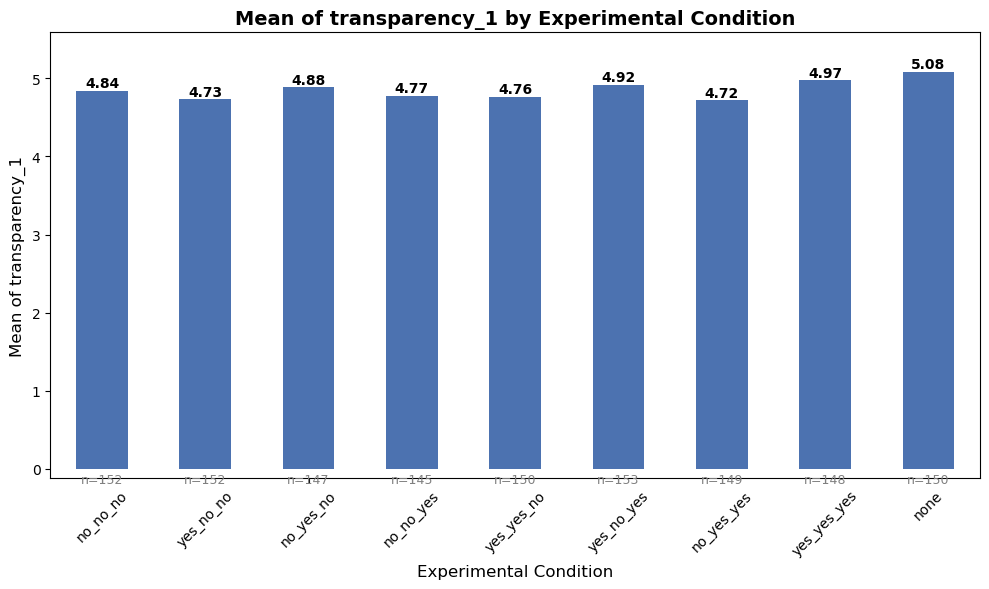

=== 分析3：按实验条件分组分析 transparency_2 ===
按condition分组的transparency_2统计:
             Mean transparency_2  Count  Total transparency_2
condition                                                    
no_no_no                4.513158    152                   686
yes_no_no               4.368421    152                   664
no_yes_no               4.510204    147                   663
no_no_yes               4.310345    145                   625
yes_yes_no                  4.44    150                   666
yes_no_yes              4.503268    153                   689
no_yes_yes              4.610738    149                   687
yes_yes_yes             4.601351    148                   681
none                    4.606667    150                   691


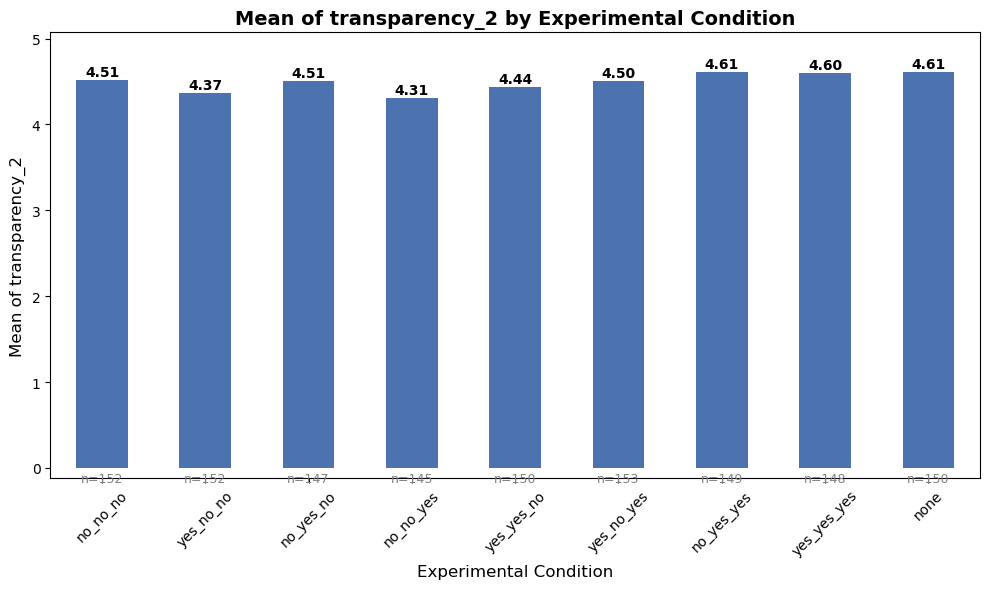

=== 分析4：按实验条件分组分析 transparency_3 ===
按condition分组的transparency_3统计:
             Mean transparency_3  Count  Total transparency_3
condition                                                    
no_no_no                4.460526    152                   678
yes_no_no               4.236842    152                   644
no_yes_no               4.319728    147                   635
no_no_yes               4.441379    145                   644
yes_yes_no                  4.22    150                   633
yes_no_yes              4.352941    153                   666
no_yes_yes              4.214765    149                   628
yes_yes_yes             4.445946    148                   658
none                    4.586667    150                   688


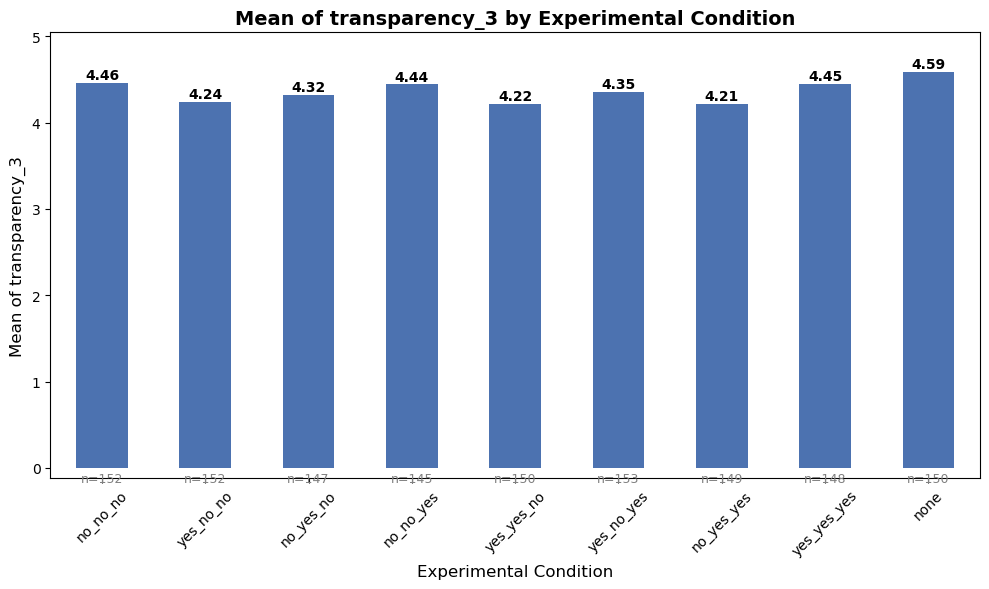

=== 分析5：按实验条件分组分析 transparency_4 ===
按condition分组的transparency_4统计:
             Mean transparency_4  Count  Total transparency_4
condition                                                    
no_no_no                4.756579    152                   723
yes_no_no               4.532895    152                   689
no_yes_no               4.619048    147                   679
no_no_yes               4.537931    145                   658
yes_yes_no              4.486667    150                   673
yes_no_yes              4.555556    153                   697
no_yes_yes              4.409396    149                   657
yes_yes_yes             4.668919    148                   691
none                        4.78    150                   717


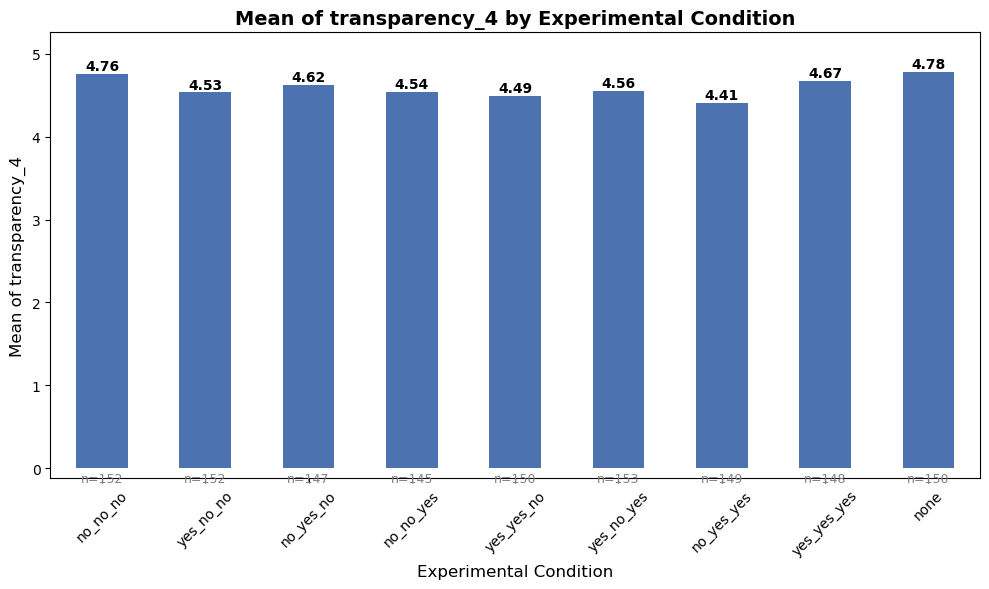

=== 分析6：按实验条件分组分析 transparency_mean ===
按condition分组的transparency_mean统计:
             Mean transparency_mean  Count  Total transparency_mean
condition                                                          
no_no_no                   4.641447    152                    705.5
yes_no_no                  4.467105    152                    679.0
no_yes_no                  4.583333    147                   673.75
no_no_yes                  4.515517    145                   654.75
yes_yes_no                 4.476667    150                    671.5
yes_no_yes                 4.581699    153                    701.0
no_yes_yes                 4.488255    149                   668.75
yes_yes_yes                4.672297    148                    691.5
none                       4.763333    150                    714.5


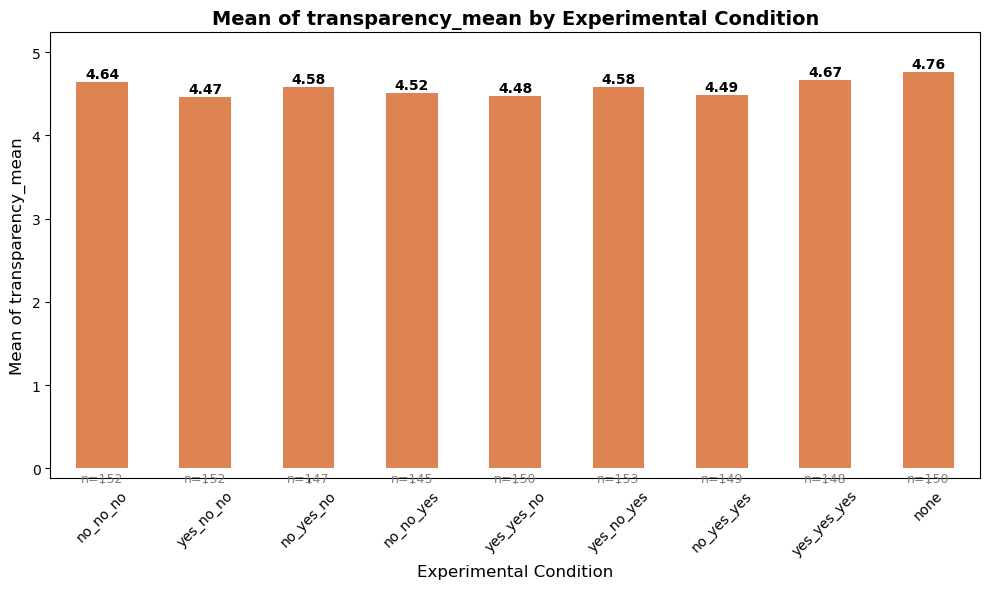

In [24]:
# 生成transparency_1, transparency_2, transparency_3, transparency_4的分组统计和可视化，以及它们均值的分组统计和可视化

transparency_vars = ['transparency_1', 'transparency_2', 'transparency_3', 'transparency_4']

for idx, var in enumerate(transparency_vars, 1):
    print(f"=== 分析{idx+1}：按实验条件分组分析 {var} ===")
    cond_stats_trans = df_clean.groupby('condition')[var].agg(['mean', 'count', 'sum'])
    cond_stats_trans.rename(columns={'mean': f'Mean {var}', 'count': 'Count', 'sum': f'Total {var}'}, inplace=True)
    cond_stats_trans = cond_stats_trans.reindex(condition_order)
    print(f"按condition分组的{var}统计:")
    print(cond_stats_trans)

    fig, ax = plt.subplots(figsize=(10,6))
    bars = cond_stats_trans[f'Mean {var}'].plot(kind='bar', ax=ax, color='#4C72B0')
    ax.set_title(f'Mean of {var} by Experimental Condition', fontsize=14, fontweight='bold')
    ax.set_xlabel('Experimental Condition', fontsize=12)
    ax.set_ylabel(f'Mean of {var}', fontsize=12)
    ax.set_xticklabels(condition_order, rotation=45)

    # 添加数值标签
    for i, (v, n) in enumerate(zip(cond_stats_trans[f'Mean {var}'], cond_stats_trans['Count'])):
        if not pd.isna(v):
            ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
        if not pd.isna(n):
            ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=9, color='gray')

    plt.ylim(-0.12, cond_stats_trans[f'Mean {var}'].max() * 1.1 if not pd.isna(cond_stats_trans[f'Mean {var}'].max()) else 1.05)
    plt.tight_layout()
    plt.show()

# 计算transparency均值
df_clean['transparency_mean'] = df_clean[transparency_vars].mean(axis=1)

print("=== 分析6：按实验条件分组分析 transparency_mean ===")
cond_stats_trans_mean = df_clean.groupby('condition')['transparency_mean'].agg(['mean', 'count', 'sum'])
cond_stats_trans_mean.rename(columns={'mean': 'Mean transparency_mean', 'count': 'Count', 'sum': 'Total transparency_mean'}, inplace=True)
cond_stats_trans_mean = cond_stats_trans_mean.reindex(condition_order)
print("按condition分组的transparency_mean统计:")
print(cond_stats_trans_mean)

fig, ax = plt.subplots(figsize=(10,6))
bars = cond_stats_trans_mean['Mean transparency_mean'].plot(kind='bar', ax=ax, color='#DD8452')
ax.set_title('Mean of transparency_mean by Experimental Condition', fontsize=14, fontweight='bold')
ax.set_xlabel('Experimental Condition', fontsize=12)
ax.set_ylabel('Mean of transparency_mean', fontsize=12)
ax.set_xticklabels(condition_order, rotation=45)

# 添加数值标签
for i, (v, n) in enumerate(zip(cond_stats_trans_mean['Mean transparency_mean'], cond_stats_trans_mean['Count'])):
    if not pd.isna(v):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
    if not pd.isna(n):
        ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=9, color='gray')

plt.ylim(-0.12, cond_stats_trans_mean['Mean transparency_mean'].max() * 1.1 if not pd.isna(cond_stats_trans_mean['Mean transparency_mean'].max()) else 1.05)
plt.tight_layout()
plt.show()


=== 分析2：按实验条件分组分析 reliability_1 ===
按condition分组的reliability_1统计:
             Mean reliability_1  Count  Total reliability_1
condition                                                  
no_no_no               5.098684    152                  775
yes_no_no              4.947368    152                  752
no_yes_no              5.312925    147                  781
no_no_yes              5.013793    145                  727
yes_yes_no             5.126667    150                  769
yes_no_yes             5.124183    153                  784
no_yes_yes             5.120805    149                  763
yes_yes_yes             5.22973    148                  774
none                        5.4    150                  810


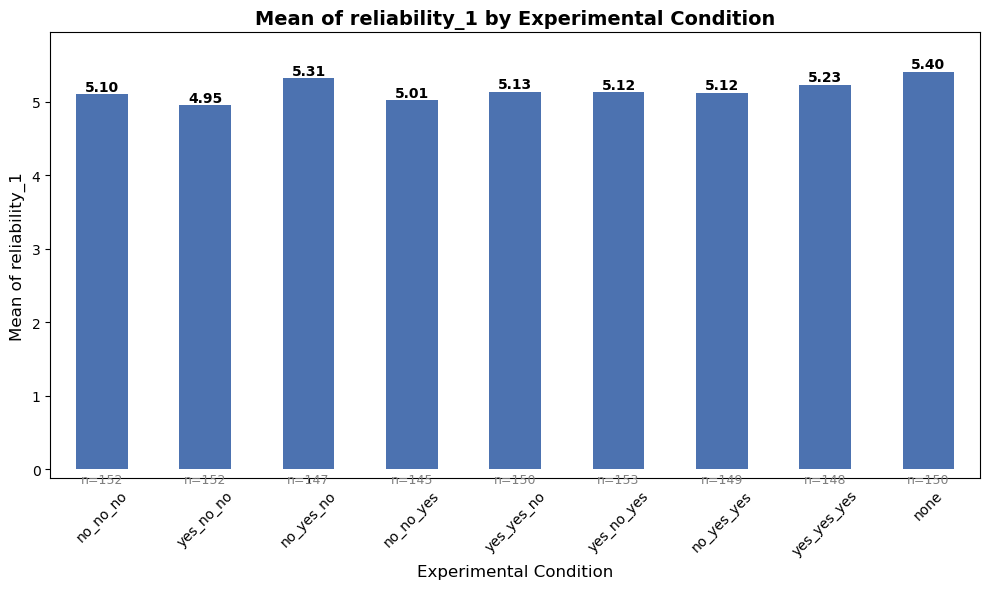

=== 分析3：按实验条件分组分析 reliability_2 ===
按condition分组的reliability_2统计:
             Mean reliability_2  Count  Total reliability_2
condition                                                  
no_no_no               4.605263    152                  700
yes_no_no                  4.25    152                  646
no_yes_no              4.414966    147                  649
no_no_yes              4.372414    145                  634
yes_yes_no                 4.24    150                  636
yes_no_yes             4.287582    153                  656
no_yes_yes             4.342282    149                  647
yes_yes_yes            4.506757    148                  667
none                       4.52    150                  678


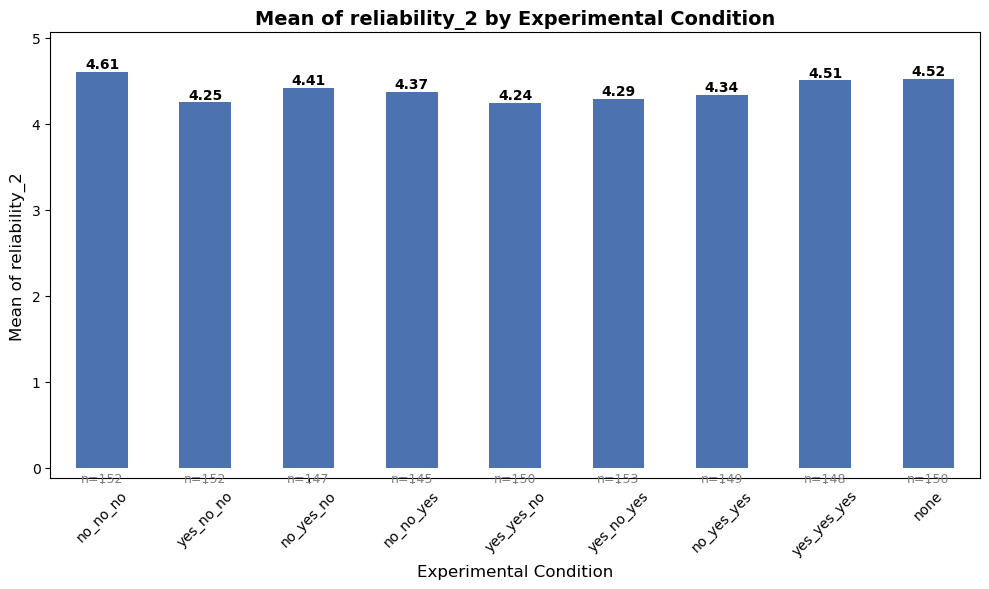

=== 分析4：按实验条件分组分析 reliability_3 ===
按condition分组的reliability_3统计:
             Mean reliability_3  Count  Total reliability_3
condition                                                  
no_no_no               4.835526    152                  735
yes_no_no              4.552632    152                  692
no_yes_no              4.598639    147                  676
no_no_yes              4.593103    145                  666
yes_yes_no             4.473333    150                  671
yes_no_yes             4.633987    153                  709
no_yes_yes             4.583893    149                  683
yes_yes_yes            4.560811    148                  675
none                   4.833333    150                  725


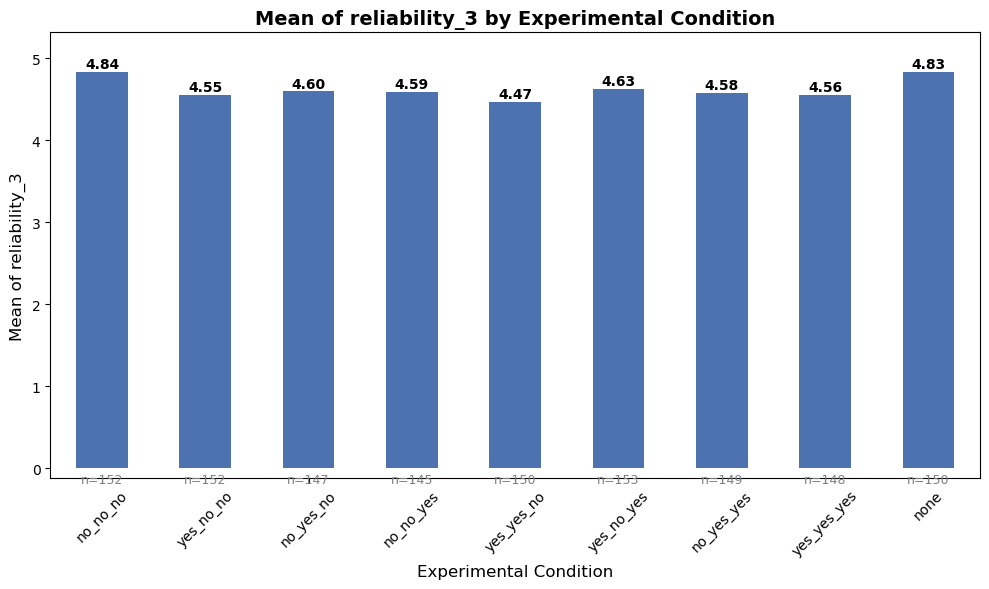

=== 分析5：按实验条件分组分析 reliability_4 ===
按condition分组的reliability_4统计:
             Mean reliability_4  Count  Total reliability_4
condition                                                  
no_no_no               4.342105    152                  660
yes_no_no              4.184211    152                  636
no_yes_no              4.190476    147                  616
no_no_yes              4.241379    145                  615
yes_yes_no             4.346667    150                  652
yes_no_yes              4.24183    153                  649
no_yes_yes             4.302013    149                  641
yes_yes_yes            4.533784    148                  671
none                       4.52    150                  678


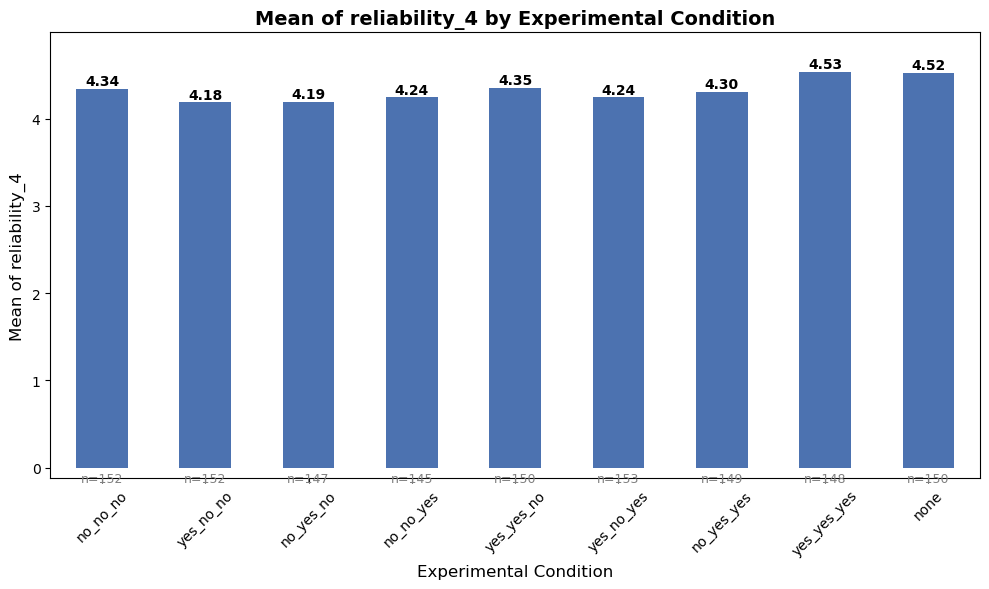

=== 分析6：按实验条件分组分析 reliability_mean ===
按condition分组的reliability_mean统计:
             Mean reliability_mean  Count  Total reliability_mean
condition                                                        
no_no_no                  4.720395    152                   717.5
yes_no_no                 4.483553    152                   681.5
no_yes_no                 4.629252    147                   680.5
no_no_yes                 4.555172    145                   660.5
yes_yes_no                4.546667    150                   682.0
yes_no_yes                4.571895    153                   699.5
no_yes_yes                4.587248    149                   683.5
yes_yes_yes                4.70777    148                  696.75
none                      4.818333    150                  722.75


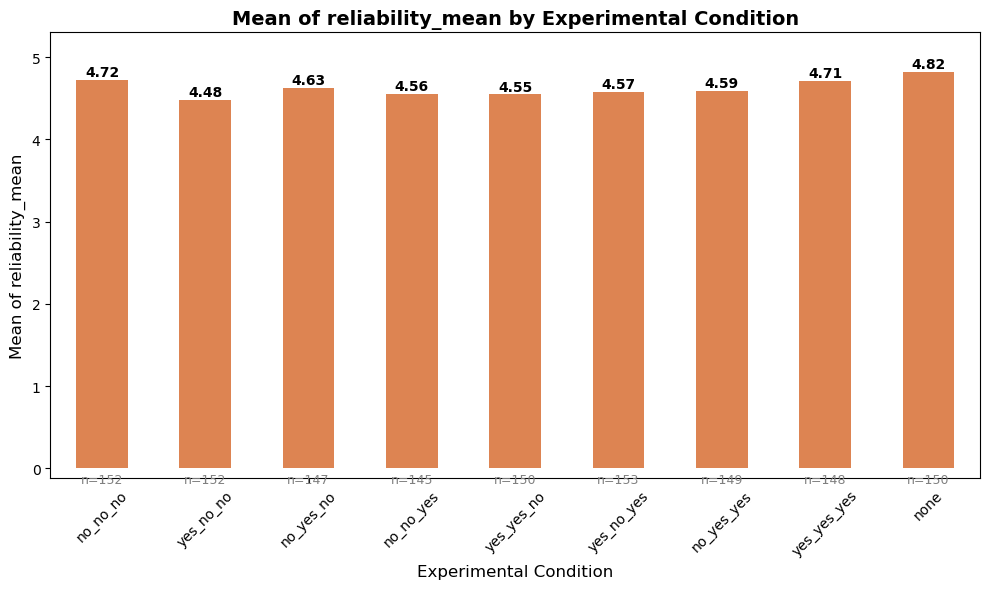

In [25]:
# 生成reliability_1, reliability_2, reliability_3, reliability_4的分组统计和可视化，以及它们均值的分组统计和可视化

reliability_vars = ['reliability_1', 'reliability_2', 'reliability_3', 'reliability_4']

for idx, var in enumerate(reliability_vars, 1):
    print(f"=== 分析{idx+1}：按实验条件分组分析 {var} ===")
    cond_stats_rel = df_clean.groupby('condition')[var].agg(['mean', 'count', 'sum'])
    cond_stats_rel.rename(columns={'mean': f'Mean {var}', 'count': 'Count', 'sum': f'Total {var}'}, inplace=True)
    cond_stats_rel = cond_stats_rel.reindex(condition_order)
    print(f"按condition分组的{var}统计:")
    print(cond_stats_rel)

    fig, ax = plt.subplots(figsize=(10,6))
    bars = cond_stats_rel[f'Mean {var}'].plot(kind='bar', ax=ax, color='#4C72B0')
    ax.set_title(f'Mean of {var} by Experimental Condition', fontsize=14, fontweight='bold')
    ax.set_xlabel('Experimental Condition', fontsize=12)
    ax.set_ylabel(f'Mean of {var}', fontsize=12)
    ax.set_xticklabels(condition_order, rotation=45)

    # 添加数值标签
    for i, (v, n) in enumerate(zip(cond_stats_rel[f'Mean {var}'], cond_stats_rel['Count'])):
        if not pd.isna(v):
            ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
        if not pd.isna(n):
            ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=9, color='gray')

    plt.ylim(-0.12, cond_stats_rel[f'Mean {var}'].max() * 1.1 if not pd.isna(cond_stats_rel[f'Mean {var}'].max()) else 1.05)
    plt.tight_layout()
    plt.show()

# 计算reliability均值
df_clean['reliability_mean'] = df_clean[reliability_vars].mean(axis=1)

print("=== 分析6：按实验条件分组分析 reliability_mean ===")
cond_stats_rel_mean = df_clean.groupby('condition')['reliability_mean'].agg(['mean', 'count', 'sum'])
cond_stats_rel_mean.rename(columns={'mean': 'Mean reliability_mean', 'count': 'Count', 'sum': 'Total reliability_mean'}, inplace=True)
cond_stats_rel_mean = cond_stats_rel_mean.reindex(condition_order)
print("按condition分组的reliability_mean统计:")
print(cond_stats_rel_mean)

fig, ax = plt.subplots(figsize=(10,6))
bars = cond_stats_rel_mean['Mean reliability_mean'].plot(kind='bar', ax=ax, color='#DD8452')
ax.set_title('Mean of reliability_mean by Experimental Condition', fontsize=14, fontweight='bold')
ax.set_xlabel('Experimental Condition', fontsize=12)
ax.set_ylabel('Mean of reliability_mean', fontsize=12)
ax.set_xticklabels(condition_order, rotation=45)

# 添加数值标签
for i, (v, n) in enumerate(zip(cond_stats_rel_mean['Mean reliability_mean'], cond_stats_rel_mean['Count'])):
    if not pd.isna(v):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
    if not pd.isna(n):
        ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=9, color='gray')

plt.ylim(-0.12, cond_stats_rel_mean['Mean reliability_mean'].max() * 1.1 if not pd.isna(cond_stats_rel_mean['Mean reliability_mean'].max()) else 1.05)
plt.tight_layout()
plt.show()


=== 分析1：按实验条件分组分析 ===
按condition分组的duration统计（已排除duration=24348的观测）:
             Mean duration  Std duration  Count  Total duration         SE  \
condition                                                                    
no_no_no        573.198675    382.490122    151           86553  31.126605   
yes_no_no       602.328947    372.949560    152           91554  30.250204   
no_yes_no       576.557823    360.497110    147           84754  29.733300   
no_no_yes       578.337931    385.551845    145           83859  32.018338   
yes_yes_no      551.180000    306.455074    150           82677  25.021952   
yes_no_yes      629.124183    341.108493    153           96256  27.576987   
no_yes_yes      591.026846    417.946394    149           88063  34.239503   
yes_yes_yes     547.817568    321.577977    148           81077  26.433547   
none            567.700000    325.055013    150           85155  26.540631   

               CI95_low   CI95_high  
condition                         

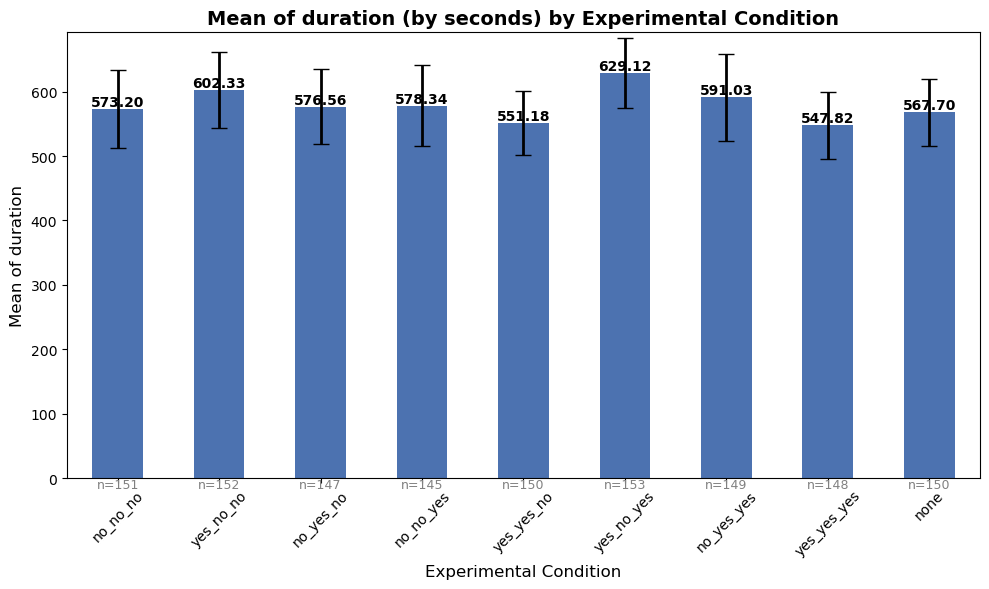

In [18]:
# =============================================================================
# 分析1：按实验条件(condition)分组分析
# =============================================================================

print("=== 分析1：按实验条件分组分析 ===")

# 指定condition的顺序以便可视化
condition_order = [
    'no_no_no', 'yes_no_no', 'no_yes_no', 'no_no_yes',
    'yes_yes_no', 'yes_no_yes', 'no_yes_yes', 'yes_yes_yes', 'none'
]

# rename Duration (in seconds) to duration in df_clean
# 将"Duration (in seconds)"重命名为"duration"
if 'Duration (in seconds)' in df_clean.columns:
    df_clean.rename(columns={'Duration (in seconds)': 'duration'}, inplace=True)

# 检查'duration'列是否存在
if 'duration' not in df_clean.columns:
    print("警告：数据中没有'duration'列，无法进行按duration的分组统计和可视化。")
else:
    # 过滤掉duration等于24348的观测值
    df_duration = df_clean[df_clean['duration'] != 24348].copy()

    # 计算均值、标准差、样本数
    cond_stats = df_duration.groupby('condition')['duration'].agg(['mean', 'std', 'count', 'sum'])
    cond_stats.rename(columns={'mean': 'Mean duration', 'std': 'Std duration', 'count': 'Count', 'sum': 'Total duration'}, inplace=True)
    cond_stats = cond_stats.reindex(condition_order)

    # 计算95%置信区间（均值±1.96*标准误）
    cond_stats['SE'] = cond_stats['Std duration'] / cond_stats['Count']**0.5
    cond_stats['CI95_low'] = cond_stats['Mean duration'] - 1.96 * cond_stats['SE']
    cond_stats['CI95_high'] = cond_stats['Mean duration'] + 1.96 * cond_stats['SE']

    print("按condition分组的duration统计（已排除duration=24348的观测）:")
    print(cond_stats)

    # 可视化
    fig, ax = plt.subplots(figsize=(10,6))
    bars = cond_stats['Mean duration'].plot(
        kind='bar', ax=ax, color='#4C72B0',
        yerr=[cond_stats['Mean duration'] - cond_stats['CI95_low'], cond_stats['CI95_high'] - cond_stats['Mean duration']],
        capsize=6, error_kw=dict(lw=2, color='black')
    )
    ax.set_title('Mean of duration (by seconds) by Experimental Condition', fontsize=14, fontweight='bold')
    ax.set_xlabel('Experimental Condition', fontsize=12)
    ax.set_ylabel('Mean of duration', fontsize=12)
    ax.set_xticklabels(condition_order, rotation=45)

    # 添加数值标签
    for i, (v, n) in enumerate(zip(cond_stats['Mean duration'], cond_stats['Count'])):
        if not pd.isna(v):
            ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
        if not pd.isna(n):
            ax.text(i, -0.05, f"n={int(n)}", ha='center', va='top', fontsize=9, color='gray')

    plt.ylim(-0.12, cond_stats['Mean duration'].max() * 1.1 if not pd.isna(cond_stats['Mean duration'].max()) else 1.05)
    plt.tight_layout()
    plt.show()